# Lab 13 - Graph Clustering Algorithms

In this lab, you will compare different graph clustering algorithms.

After filling this notebook and running all the cells, rename the file **lab13.ipynb** to **netid_lab13.ipynb**, include your **well commented** code, and submit it by email. Avoid unneeded steps/computations and make sure your code runs before submitting it. Grading is based on your submission which is due at **9 p.m. Dec 12, 2017**. There is no late policy. No late submissions will be accepted.

You will need to install [numpy](https://docs.scipy.org/doc/numpy-1.13.0/user/install.html) and [sklearn](http://scikit-learn.org/stable/) for this lab. Use this command `pip install --user numpy` and `pip install --user sklearn` to install numpy on your machine. 

You will need the following helper function.

In [85]:
%matplotlib inline
from pylab import *
import random as rnd
import networkx as nx
import numpy as np
from __future__ import division

rnd.seed(2333)

def draw_graph(graph, labels=None, graph_layout='spring',
               node_size=1600, node_color='blue', node_alpha=0.3,
               node_text_size=12,
               edge_color='blue', edge_alpha=0.3, edge_tickness=1,
               edge_text_pos=0.3,
               text_font='sans-serif'):
    """ 
    Based on: https://www.udacity.com/wiki/creating-network-graphs-with-python
    We describe a graph as a list enumerating all edges.
    Ex: graph = [(1,2), (2,3)] represents a graph with 2 edges - (node1 - node2) and (node2 - node3)
    """
    
    rcParams['figure.figsize'] = 6, 6  # that's default image size for this interactive session
    # create networkx graph
    G=nx.Graph()

    # add edges
    for edge in graph:
        G.add_edge(edge[0], edge[1])

    # these are different layouts for the network you may try
    # shell seems to work best
    if graph_layout == 'spring':
        graph_pos=nx.spring_layout(G)
    elif graph_layout == 'spectral':
        graph_pos=nx.spectral_layout(G)
    elif graph_layout == 'random':
        graph_pos=nx.random_layout(G)
    else:
        graph_pos=nx.shell_layout(G)

    # draw graph
    nx.draw_networkx_nodes(G,graph_pos,node_size=node_size, 
                           alpha=node_alpha, node_color=node_color)
    nx.draw_networkx_edges(G,graph_pos,width=edge_tickness,
                           alpha=edge_alpha,edge_color=edge_color)
    nx.draw_networkx_labels(G, graph_pos,font_size=node_text_size,
                            font_family=text_font)
    # show graph
    plt.show()

**You will need the following functions from Lab 12.**

In [86]:
def adjacency_to_graph(adjacency):
    assert all(adjacency == adjacency.T)
    graph = []
    # your code goes here
    graph = zip(*np.where(adjacency == 1))
    return graph

def G(n, p):
    graph = np.zeros((n, n))
    rand = np.random.rand(n, n)
    threshold = np.ones((n, n)) * p 
    graph = (rand < threshold) * 2
    graph = np.triu(graph)
    graph = (graph + graph.T)/2
    graph[range(n), range(n)] = 0
    return graph

def SBM(n, k, p, q):
    assert (n % k == 0)
    graph = np.zeros((n, n))
    community_size = int(n/k)
    
    # create connections between communities
    graph = G(n, q)
    
    for l in xrange(k):
        # create community l
        # your code goes here
        community = G(community_size, p)
        bias = int(l * community_size)
        graph[bias:(bias + community_size), bias:(bias + community_size)] = community
    return graph

def get_laplacian(adjacency):
    # compute the degree matrix
    degree = np.diag(np.sum(adjacency, axis=1))
    # compute the Laplacian
    laplacian = degree - adjacency
    return laplacian

def get_laplacian_vectors(laplacian, k):
    u, s, v = np.linalg.svd(laplacian)
    return u[:, -k:]

def kmeans(v, k):
    labels = np.zeros(len(v))
    from sklearn.cluster import KMeans
    kmeans = KMeans(n_clusters=k)
    labels = kmeans.fit_predict(v)
    return labels

def spectral_clustering(A, k):
    labels = np.zeros(len(A))
    # get its laplacian
    laplacian = get_laplacian(A)
    # get the eigenvectors
    v = get_laplacian_vectors(laplacian, k)
    # perform k-means clustering on eigenvectors
    labels = kmeans(v, k)
    # return the label
    return labels

def inter_cluster_edges(A, labels):
    num_edges = 0
    # your code goes here
    weight = np.ones(A.shape)
    for label in set(labels):
        nodes = np.where(labels==label)[0]
        weight[np.ix_(nodes, nodes)] = 0
    return np.sum(A * weight) / 2

## Problem 0: Evaluation Metric (10 pts)

In this lab, the performance is evaluated in terms of the "accuracy" of the recovered cluster, in addition to the number of inter cluster edges. For bisection, since we know the ground truth -- the first half of the vertices belongs to one cluster, and the rest half belongs to another. The "accuracy" of the recovered labels is formally defined as,
$$ {\rm accuracy} = \frac{1}{n} \max\left(\sum_{i=1}^n [{\rm ground\_truth}(i) = {\rm labels}(i)], \sum_{i=1}^n [{\rm ground\_truth}(i) \not= {\rm labels}(i)], \right), $$
where the elements in `ground_truth` and `labels` belong to ${0, 1}$. 

Fill in the following code to compute the accuracy of the labels given ground truth.

In [87]:
def accuracy(ground_truth, labels):
    acc = 0.0
    eq_max = 0.0
    neq_max = 0.0
    for i in range(len(labels)):
        if ground_truth[i] == labels[i]:             # This keeps a count of the vertices that are correctly identified 
            eq_max += 1.0
        else:
            neq_max += 1.0                           # This keeps a count of the vertices that don't match up to their labels
            
    acc = (1/(len(labels))) * max(eq_max, neq_max)       # Calculate accuracy based on the equation above
    return acc

## Problem 1: Bethe Hessian Clustering (20 pts)

Let $G=(V,E)$ be a graph with $n$ vertices. Denote by $A$ its adjacency matrix, and by $D$ the diagonal matrix defined by $D_{ii} = d_i$ is the degree of vertix $i$. We then define the Bethe Hessian matrix, sometimes called the deformed Laplacian, as
$$H(r) = (r^2 - 1) \mathbb{1} - rA + D,$$
where $\mathbb{1}$ is a $n\times n$ identity matrix. 

The [Bethe Hessian clustering algorithm](https://arxiv.org/pdf/1406.1880.pdf) works as follows: let $c$ be the average degree of the graph, we compute the eigenvectors associated with the negative eigenvalues of $H(\sqrt{c})$ and $H(-\sqrt{c})$, and cluster them with a standard clustering algorithm ($k$-means).  

Fill in the functions to recover clusters using the Bethe Hessian clustering.

In [88]:
import math
import sklearn
from sklearn.cluster import KMeans
def get_bethe_hessian_matrix(adjacency, r):
    '''
    Output the Bethe Hessian matrix associated with the adjacency matrix and a regularizer r.
    '''
    h = np.zeros(adjacency.shape)
    # your code goes here
    
    identity = np.identity(adjacency.shape[0])        # Set up an identity matrix needed for the equation
    
    degree = np.diag(np.sum(adjacency, axis=1))       # Set up the degree matrix corresponding to the adjacency matrix given

    h = (r**2 - 1)*identity - r*adjacency + degree    # Fill in the "h" matrix according to the corresponding to the equation above
    
    return h

def get_bethe_hessian_vectors(h):
    '''
    Output the eigenvectors associated with the negative eigenvalues of h
    '''
    eig_vals, eig_vecs = np.linalg.eig(h)
    v = []
    for i in range(len(eig_vals)):              # Store all the indices of the negative eigenvalues in v
        if eig_vals[i] < 0:
            v.append(i)
    # your code goes here
    v_ret = np.zeros((len(h), len(v)))
    for i in range(len(v)):
        v_ret[:,i] = eig_vecs[:, v[i]]          # v_ret holds the eigenvectors corresponding to the negative eigenvalues
    
    return v_ret

def bethe_hessian_clustering(adjacency, k):
    '''
    Output the graph clusters using the Bethe Hessian clustering
    '''
    labels = np.zeros(len(adjacency))
    
    deg_matrix = np.zeros((adjacency.shape[0], adjacency.shape[1]))
    deg_count = 0
    # create a deg_matrix to hold the degree of each node
    for i in range(adjacency.shape[0]):
        for j in range(adjacency.shape[1]):
            if adjacency[i, j] == 1:
                deg_count += 1         
        deg_matrix[i, i] = deg_count
        deg_count = 0

    avg = 0
    for i in range(deg_matrix.shape[0]):
        avg += deg_matrix[i, i]                     
    
    avg = avg/(adjacency.shape[0])             # Get the average degree of the adjacency graph
    
    
    # The following code follows the bethe hessian clustering algorithm
    # fin_vecs holds the eigenvectors corresponding to the negative eigenvalues of 
    # H(sqrt(c)) and H(-(sqrt(c)))
    h_pos = get_bethe_hessian_matrix(adjacency, np.sqrt(avg))
    h_neg = get_bethe_hessian_matrix(adjacency, -1*(np.sqrt(avg)))
    
    vecs_pos = get_bethe_hessian_vectors(h_pos)
    vecs_neg = get_bethe_hessian_vectors(h_neg)
    
    fin_vecs = np.append(vecs_pos, vecs_neg, axis=1)
    
    # Run kmeans to get labels
    kmeans = KMeans(n_clusters = k).fit(fin_vecs)
    labels = kmeans.labels_
    # your code goes here
    return labels

Try this.

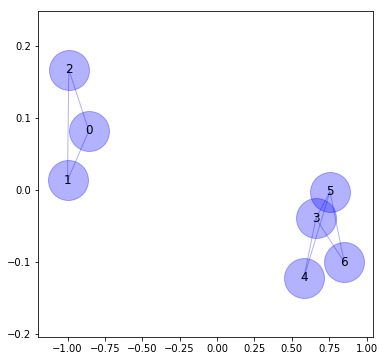

array([1, 1, 1, 0, 0, 0, 0], dtype=int32)

In [89]:
adjacency = np.array([[0, 1, 1, 0, 0, 0, 0],
                      [1, 0, 1, 0, 0, 0, 0],
                      [1, 1, 0, 0, 0, 0, 0],
                      [0, 0, 0, 0, 1, 1, 1],
                      [0, 0, 0, 1, 0, 1, 0],
                      [0, 0, 0, 1, 1, 0, 1],
                      [0, 0, 0, 1, 0, 1, 0],])
draw_graph(adjacency_to_graph(adjacency))
bethe_hessian_clustering(adjacency, 2)

## Problem 2: Semidefinite Programming (50 pts)

In the previous labs, we used spectral methods to reconstruct graph clusters. In this section, we develop an graph clustering algorithm using semidefinite programming. This algorithm is specially designed for bisection, i.e., cluster graphs into two parts (instead of $k$ parts). 

First of all, search for a configuration of the $n$ unit-length $m$-components row vectors $x_i \in \mathbb{R}^m$, $\|x_i\| = \sqrt{x_i^{\top} x_i} = 1$, optimizing the following objective function
$$\max \sum_{(i,j)\in E} x_i^{\top} x_j, \qquad \textrm{subject to } \sum_{i} x_i = 0. \qquad (1)$$

Let us call $x^* = \{x_1^*, ..., x_n^*\}$ the maximizer. To project back the maximizer to a vector of $n$ reals, we first compute the matrix $\Sigma \in \mathbb{R}^{m\times m}$ measuring the correlations among the $m$ components of the maximizer averaged over the entire graph,
$$\Sigma_{jk} = \frac{1}{n} \sum_{i=1}^n (x_i^*)_j (x_i^*)_k,$$
whose principal component we call $v_1$, and then we project each $x_i$ over $v_1$. Thus the rank $m$ SDP estimator has the label,
$${\rm label}(i) = \left\{\begin{array}{ll} 0 & \textrm{ if $x_i^{\top} v_1$ < 0} \\ 1 & \textrm{otherwise.} \end{array}\right.$$

Fill in the following function to get the label with the maximizer.

In [90]:
def get_labels(x):
    '''
    Arguments:
      - x of shape (m, n), the maximizer each columns corresponds to the $m$-dimensional vector.
    '''
    num_nodes, m = x.shape
    labels = np.zeros(num_nodes)
    
    # Create the sigma matrix required to get the eigenvalues and eigenvectors needed
    sig_matrix = np.zeros((m, m))
    for j in range(x.shape[1]):
        for k in range(x.shape[1]):
            product = 0
            for i in range(x.shape[0]):
                product = x[i, j] * x[i, k]
            sig_matrix[j, k] = product/(x.shape[1])
    
    eig_vals, eig_vecs = np.linalg.eig(sig_matrix)
    max_val = eig_vals[0]
    max_index = 0
    for i in range(len(eig_vals)):
        if eig_vals[i] > max_val:
            max_val = eig_vals[i]
            max_index = i                              # max_index now contains the index of the max eigenvalue
    
    principal_component = eig_vecs[:, max_index]        # principal component now contains the principal eigenvector
    
    for i in range(num_nodes):                      # Assign labels based off the SDP estimator
        if np.dot(x[i], principal_component) < 0:
            labels[i] = 0
        else:
            labels[i] = 1
    # your code goes here
    return labels

The algorithm we used to find the maximizer in (1) is block-coordinate descent. At each step of the algorithm we update spins in a random order $\pi$, and align each spin to its local field,
$$x_{\pi(i)} = \frac{\sum_{j: (\pi(i), j)\in E} x_j - M(x)}{\|\sum_{j: (\pi(i),j)\in E} x_j - M(x)\|}, \qquad (2)$$
with the global magnetization being $M(x) = \sum_{i} x_i, \forall \ i = 1,2,...,n$. We always check that the global magnetization becomes very small at large times, $\lim_{t\to\infty} M(t) = M(\infty) \ll 1$. As a stoping criterion, we check the largest variation in a spin during the last step, $\Delta_{\max} = \max_{i} \|x_i^{new} - x_i^{old}\|$, and we stop when $\Delta_{\max} < \varepsilon$, with $\varepsilon = 10^{-3}$ or $10^{-4}$. Note that the updating rule has to be executed **sequentially** and the global magetization $M$ is also updated whenever $x$ is updated.

Fill in the following function for block-coordinate descent.

In [91]:
def one_step(adjacency, x):
    '''
    Output the updated spin, calculated using (2)
    '''
    delta_max = 0
    num_nodes = len(x)
    order = np.random.permutation(num_nodes)
    for i in order:
        # your code goes here
        temp_sum = np.zeros((1, x.shape[1]))
        M_x = np.zeros((1, x.shape[1]))
        for j in range(num_nodes):
            M_x += x[j]
            if adjacency[i, j] == 1:                # update temp_sum according to the equation with the neighboring nodes
                temp_sum += x[j]
        
        denom = float(np.linalg.norm(temp_sum - M_x))         # Set the normalized denominator; set to 1 if denom == 0
        if denom == 0:
            denom = 1.0
        
        updated_x = (temp_sum - M_x)/denom         # Calculate the value which is x_new
        
        if np.linalg.norm(updated_x - x[i]) > delta_max:
            delta_max = np.linalg.norm(updated_x - x[i])         # Update delta_max if the x_new - x_old (normalized) is greater than delta max
            
        x[i] = updated_x                  # Set x as x_new
        
    return x, delta_max 

Assembly the functions above to form a graph clustering algorithm based on semidefinite programming.

In [92]:
def sdp_clustering(adjacency, m, epsilon=1e-3):
    num_nodes = len(adjacency)
    labels = np.zeros(num_nodes)
    # your code goes here
    # Either this block is incorrect, or my one_step function is incorrect, as this block runs infinitely although I have my while
    # statement. I ran out of time trying to find the error as I had finals to study for
    # intialize x randomly such that ||x_i|| =1
    x = (np.random.rand(num_nodes, m) > 0.5) * 2.0 - 1
    x /= np.linalg.norm(x, axis=1, keepdims=True)
    
    delta_max = 10000000000
    # block-coordinate descent
    while delta_max > epsilon:
        x_new, delta_max = one_step(adjacency, x)
        # now you already have the maximizer ready
        # calculate the matrix 
        labels = get_labels(x_new)
        print delta_max

    return labels

The main parameter in this algorithm is the number of components $m$, and we expect the behavior of the algorithm to depend strongly on $m$. Fill in the following code to evaluate the performances (in terms of the number of inter-cluster edges and accuracy) by plotting the evaluation metric (accuracy and the number of inter-cluster edges) against $m$. Observe what happened and try to explain why this happens.

In [69]:
# your code goes here
L = 100 # number of iterations to average over
n = 100
ground_truth = np.array([0]* int(n/2) + [1]* int(n/2))
k = 2
p = 0.3
q = 0.2

ms = np.arange(1, 16)
# your code goes here
num_edges = np.zeros((len(ms), L))
baselines = np.zeros((len(ms), L))
adjacency = SBM(n, k, p, q)
for i, q in enumerate(ms):
    for l in xrange(L):
        labels = sdp_clustering(adjacency, k)
        num_edges[i, l] = inter_cluster_edges(adjacency, labels)
        baselines[i, l] = inter_cluster_edges(adjacency, ground_truth)
        
rcParams['figure.figsize'] = 8, 6
plt.figure()
plt.plot(qs, np.average(num_edges, axis=1), marker='s', label='spectral clustering')
plt.plot(qs, np.average(baselines, axis=1), marker='o', label='baseline')
plt.legend()
plt.xlabel('q')
plt.ylabel('number of cross edges')

1.99929897015
1.99691268314
1.99936829302
1.96247724665
1.61612236442
0.44226420927
0.249702315726
0.185378692653
0.138585945376
0.255954181097
0.126918722783
0.102397409698
0.111434480879
0.0713742391249
0.0819042039234
0.0920659091607
0.0369830777047
0.0821773506216
0.0448792219317
0.0791291159616
0.0838993022758
0.0838573930571
0.0846557070647
0.0605819520205
0.0810657939021
0.0953748492071
0.135420922126
0.0678828482419
0.123013463091
0.154378990997
0.0911354085098
0.145750581506
0.0668243979117
0.153024062697
0.121943436228
0.122777769364
0.163114701934
0.156074039715
0.159690098656
0.152792027727
0.104699503477
0.140706354412
0.12932605662
0.194241022438
0.119393322708
0.20268815308
0.14136521035
0.147833719195
0.122577683464
0.113447228955
0.0539480298535
0.0587143325876
0.0367828324614
0.0277751471581
0.0217438869099
0.0153145724762
0.009971793447
0.00706768613088
0.00551009335504
0.0050237303307
0.00362955533445
0.00223494268085
0.00314880973
0.00152565652688
0.000961999644622

0.0988117725378
0.108882719806
0.0875715408155
0.0601164829812
0.106103344212
0.0908124956739
0.0604396624825
0.0887863693929
0.0614864789917
0.0649364803706
0.0758397246564
0.0456390855993
0.0790356870515
0.0654369984408
0.0420156175301
0.0371503238673
0.0461678809905
0.0217699724633
0.0270098795713
0.0223173051819
0.0226981672851
0.0251589087303
0.0263611578538
0.0230868584058
0.0220437703995
0.0145050011004
0.0137111953367
0.00946315869538
0.0125950757869
0.0130638551329
0.0107157200498
0.00902498454354
0.00847992277431
0.00948120516067
0.0109015942929
0.00921419621162
0.00640397515979
0.00574278698531
0.00542249524089
0.0059236040787
0.00662019257703
0.0039107514458
0.00537780655369
0.00363168046176
0.00383496589276
0.0036141899748
0.00493603159571
0.00355534636495
0.00309234052121
0.00335600284674
0.00265835485143
0.00411605756461
0.00246281620175
0.00219856113847
0.0020954001173
0.00187241406722
0.00147912452553
0.00183364901464
0.00157745864993
0.00206435629692
0.00156040152252


0.0317277738015
0.0260743770121
0.0250634079173
0.0291074594957
0.0296840947614
0.0307772329456
0.0221019962285
0.0266978246767
0.0208710068251
0.0250452586723
0.0161206764536
0.019029671763
0.0142668315666
0.0248796105077
0.0176450898026
0.0131571411182
0.0275790276851
0.0173778244315
0.0153481908523
0.0284680515774
0.01024331626
0.0148460161763
0.0179201826007
0.0117266322727
0.0214375217249
0.0191179559457
0.010918241271
0.0167936057152
0.0223624882994
0.010321974726
0.0230813000988
0.012460831543
0.0228563740067
0.0145643452118
0.0124424583353
0.0159980844111
0.0120225854182
0.0181421468198
0.0100917534542
0.019291732123
0.0179154682276
0.0153115226603
0.00908392560509
0.013990170252
0.0161967813351
0.00910112091189
0.0160871731248
0.0083536724932
0.014966070868
0.013451527136
0.00793275218954
0.0168739351167
0.00810375772415
0.0077041243942
0.0113646561563
0.0134895901777
0.00534232328761
0.0113023121946
0.0135186233111
0.00877521677295
0.00930753273767
0.0109770923459
0.006725592

0.0190830090039
0.017509261713
0.0266939941167
0.0124136211135
0.0142518855007
0.0187696164104
0.0200435805025
0.0199982776332
0.0170422437529
0.00906376711366
0.0147850569471
0.0218035855851
0.0165660743282
0.0104914304096
0.0153352265396
0.015277930034
0.0159492665585
0.0188025004014
0.0233381046361
0.00979988989329
0.0161145315536
0.0148023578031
0.0125293280263
0.0143520136056
0.0217029255277
0.0182703983939
0.00912396110789
0.0151663273873
0.0221031365427
0.0078847719245
0.019365364179
0.00779847310529
0.015555310547
0.0164875279023
0.012124384303
0.00855604167998
0.014423260683
0.00553312106585
0.0103071091986
0.0126222049831
0.0134915691005
0.00622035524399
0.0108541228916
0.0103298005841
0.00898580904295
0.00580969988599
0.00698701465709
0.00691760731695
0.00629412895983
0.00862202647417
0.0041068885966
0.00481596603833
0.0038443337294
0.00489352431516
0.00384968329097
0.00475269137446
0.00308951234097
0.00426905133416
0.00481050090508
0.00299668347084
0.00532936715041
0.002129

0.00241583476948
0.00100960993152
0.00194812855651
0.00215877908179
0.00125977962216
0.0013226920271
0.00140223386093
0.00106179594138
0.00168043597549
0.000638332361201
1.99906236738
1.9612735709
1.75796250517
1.72525923842
0.967956017823
0.443568676386
0.465081701918
0.315651035996
0.335988244332
0.373459688371
0.441144844328
0.445716233634
0.159025585298
0.541420499958
0.433140000675
0.431982596907
0.411041932187
0.258317207011
0.240761991036
0.393148043868
0.328960359242
0.564011284807
0.381287343582
0.364163829819
0.194825617364
0.144917980808
0.0639112958406
0.0882751517235
0.0918018417462
0.0541002371819
0.026625861852
0.0279828446171
0.0246698134002
0.0209062053903
0.0160705342869
0.0179770560571
0.012222455914
0.0153233550906
0.00871555359976
0.0134975110467
0.00730938049868
0.010433912415
0.00451465888713
0.0087545887777
0.00504359381808
0.00505857132174
0.00417253849675
0.00489489425575
0.00344148702992
0.00300101954083
0.0035823017537
0.00248156157914
0.00208586716859
0.001

0.0259192370895
0.0147321000746
0.0120814584764
0.0134388870898
0.0158966547529
0.0116363126038
0.00882269801904
0.00953599247165
0.00928963976778
0.00580445678808
0.00856491641835
0.00532171147864
0.00420812062914
0.00345951963258
0.00356296482994
0.00384324140161
0.00383937580645
0.00308324650508
0.00311108710243
0.00261714911968
0.00195110909074
0.00129048952789
0.001874872516
0.00102245180253
0.00146363991815
0.000944816609367
1.99934813148
1.98971590539
1.58731576329
1.17144982418
0.598349100637
0.302402506651
0.251255099979
0.113954703515
0.123394601442
0.141948609694
0.133926269345
0.188595056455
0.194753834651
0.227605153121
0.197951425415
0.214546157352
0.127975524348
0.262705282073
0.127686695242
0.139107536756
0.149741535209
0.151638676458
0.0926360300207
0.163584536957
0.098002605334
0.12530470418
0.0854666686502
0.061305886678
0.0679070191592
0.0550053047219
0.0844219886969
0.0710534500455
0.081741538768
0.050606953355
0.117333056139
0.093686313796
0.13838471521
0.11401204

0.00310839804135
0.00369750242333
0.00253203066152
0.00237926407376
0.00216110260193
0.00180393145023
0.00239786853087
0.00190894784081
0.00147301362465
0.00109572028307
0.0017033860097
0.00116338351028
0.000936069906798
1.99985548707
1.97018878919
1.88835888621
1.20509176732
1.06146180961
0.695562984647
0.23663552127
0.123298705695
0.108726376459
0.103912843797
0.0495681640329
0.0343068351959
0.0354645339358
0.0192281188971
0.0212849126761
0.013308079317
0.0124219286635
0.0068111996727
0.00840408337225
0.00358628592663
0.00276699220031
0.00334726857124
0.00299430552099
0.00162574080585
0.00108505790523
0.00124588592487
0.000612624390518
1.99970352917
1.99991997262
1.93502165089
1.20849836279
0.614181497007
0.339026490758
0.310173642092
0.243029299234
0.129968763609
0.154188860793
0.119662343573
0.0730038774346
0.0833735176087
0.0512769319474
0.0672630457728
0.0597640356756
0.0580644087365
0.0625293526984
0.0644022938181
0.0687353831226
0.0673530600285
0.0586551505019
0.0822302891508
0

0.284143474195
0.236611835707
0.11186722197
0.092420657806
0.162082755075
0.100198396821
0.123765208253
0.0315051871514
0.0853201364762
0.0707911653924
0.0328808708525
0.1047283406
0.0293813973613
0.0929128031075
0.0257647791144
0.0886255686113
0.0816732575175
0.0881753834866
0.059337998873
0.0805524754376
0.0212880582154
0.102030274032
0.11393886845
0.0638990503652
0.0742438875512
0.0809573805664
0.0919595328488
0.0449217254966
0.0998664302057
0.0892120433683
0.0968944694371
0.100848519108
0.0513718956664
0.101590417564
0.0551503444773
0.0770515060478
0.0918534498375
0.0768006519602
0.0526319316195
0.0520329045416
0.0425142960465
0.0411654286409
0.0481226692244
0.0300431966961
0.0365857789208
0.0323838325906
0.0343326991874
0.0309413046792
0.0170541937173
0.019774063115
0.0219329046989
0.02108929824
0.0187211386121
0.013609825671
0.0153368915401
0.0111971027763
0.0151869810801
0.00909728012371
0.0128947187649
0.00920145379291
0.00996722128139
0.00958227483812
0.00684333013072
0.007472

0.258355429314
0.186149569095
0.211264432444
0.152718662799
0.162654573625
0.141649001668
0.135406400964
0.0616946997972
0.0913160240567
0.0694334425749
0.0218126742578
0.0251993409088
0.0189652828094
0.00889911499464
0.00582562141332
0.00632392844048
0.00360881341683
0.00323641331552
0.00332281233696
0.00227019703084
0.00189205576908
0.00173666613089
0.000855348150979
1.99900099063
1.91451681034
1.99902102977
1.03799742363
1.40276828712
0.365410780389
0.595786522431
0.359343123264
0.863264444075
0.479549648855
0.337548789777
0.393427201278
0.636647090368
1.30362031122
0.420923195499
0.752850580159
0.502719034644
0.510927381976
0.233016148571
0.389102008934
0.188094329851
0.169054091055
0.128453486712
0.089171107923
0.0649738739119
0.0841929280124
0.0787298598043
0.0457471121
0.0631427920608
0.0532994268921
0.0305431202335
0.0404829674163
0.0344573626432
0.0334362738648
0.02068415462
0.0271956489369
0.0332735800529
0.0192683582954
0.0351046256302
0.0164480498995
0.0127798477543
0.02323

0.218762383021
0.0969868606831
0.220625310598
0.239922453853
0.217704787764
0.094352377953
0.230589274909
0.079829794925
0.150141985059
0.0489057088212
0.0525305798007
0.0245820509975
0.041528376813
0.0378796037939
0.0242475526637
0.0158501627387
0.0211667671025
0.0175094690898
0.0191585074853
0.0190456580123
0.00543899169211
0.0167649725407
0.0109581052582
0.0141622819938
0.00385934333959
0.0117270285504
0.0103273903274
0.00551054210843
0.00489190762261
0.00846215612709
0.00266015131095
0.00845517257927
0.00290695282803
0.0050022619055
0.00197037099904
0.00702441433177
0.00536197325942
0.0019355736003
0.00564577173656
0.00159148205669
0.00432443948121
0.00239308514297
0.00454814047051
0.00120650323502
0.00323764553534
0.00254087293309
0.00278849397806
0.0014530694307
0.00209656159191
0.000793055262044
1.99758353786
1.9928693443
0.999295271336
0.689487294689
0.411431386301
0.318707056803
0.25814374414
0.178510166002
0.150617100962
0.103701823226
0.148017132197
0.253321269093
0.29149402

0.00302382648225
0.00179631967643
0.00204185442591
0.0023808959833
0.00214925600998
0.00117754278381
0.0013926083158
0.00166964810367
0.00124757983055
0.00195242507935
0.00149590426372
0.000785305082743
2.0
1.99706995263
1.50000098876
0.583423663198
0.362450951348
0.222528529534
0.211272057603
0.251926699977
0.237175694009
0.16239432637
0.131170139537
0.179445309729
0.0956817297443
0.158629662674
0.108690476456
0.0722358294937
0.111399241652
0.0655756659821
0.126462940049
0.0747881281738
0.145668966751
0.0779914363262
0.0870500034802
0.111037437798
0.0642643656559
0.0750486213067
0.0523947233066
0.0556003965838
0.0582830943271
0.028441730294
0.044599266669
0.023232349769
0.0253034162876
0.0161089605989
0.0194893467365
0.0191549687948
0.0136645331235
0.0129630791021
0.0156171738798
0.0101427480528
0.0106557512967
0.00920409604445
0.00951327753446
0.0085603298363
0.00505974197695
0.00946390734202
0.00631936166702
0.00663158539794
0.00476885881126
0.00816871449078
0.00501342840882
0.00492

0.275926542565
0.203355840462
0.139336753671
0.0594535480744
0.0706529826569
0.0294270440662
0.0349852316744
0.0177942721184
0.0151752131429
0.0108894501854
0.00720742602791
0.00702290955525
0.00556898834076
0.0025089952848
0.00244791899249
0.00204019670852
0.00112877165884
0.000631758753724
1.99762463207
1.98462464223
1.99570583729
1.07794495416
0.394292546685
0.241927128103
0.241684891578
0.252885187721
0.159547432333
0.189149119613
0.192449740396
0.204579629326
0.334902723501
0.375277954657
0.434723317634
0.505882081158
0.550221509028
0.456885078373
0.367573365115
0.302289966589
0.246195093759
0.257734121856
0.229600362667
0.28132570625
0.133841096418
0.167733562864
0.34989778741
0.211611591056
0.500375020264
0.386535341453
0.294598050451
0.216852000754
0.183633962002
0.10980922604
0.155367834249
0.12068325446
0.132774948203
0.168565401313
0.129929724651
0.186256183216
0.138721414387
0.133212676867
0.19846836974
0.253690617112
0.149108690593
0.136038362902
0.105087792063
0.076377228

0.0264825284557
0.0192420907524
0.0162936103561
0.011419437585
0.0117190697047
0.0137202380938
0.00995497918173
0.00864567185812
0.00844581572853
0.00642569515748
0.00805939028571
0.00541017316759
0.0049016274514
0.00440233490803
0.00538959932789
0.00402574252351
0.00484780296971
0.00316418952511
0.00386632987171
0.00252203711804
0.00387818822185
0.00229307649719
0.0029118452815
0.00144820070422
0.00234425388253
0.00222322599872
0.00150453790157
0.00151043990609
0.00202024583869
0.00127640233615
0.00154017657292
0.00109133952892
0.00101577856379
0.001426221561
0.000949839439418
1.99898891999
1.99871880495
1.89572894907
1.96209391387
1.82184714812
0.816588261603
0.628965122448
0.531564667151
0.332312970223
0.471440745782
0.264157518803
0.281430519156
0.20760651362
0.175377738058
0.0649954308463
0.105639998343
0.0372302267096
0.048246016524
0.0297328890023
0.024844639975
0.013331908929
0.00827738067791
0.00885728236742
0.00638040224631
0.00320825509624
0.00372416106767
0.00247205299195
0

0.00432840398141
0.00580107547208
0.0049772174943
0.00269752341442
0.00273363208222
0.004890306457
0.00189438884603
0.00326575465246
0.00228886586999
0.00279005610451
0.00200648998214
0.00253950236221
0.00163413095195
0.002171428867
0.00191417083459
0.00272774868293
0.00165466412292
0.00203285425776
0.00171417427277
0.00143112881971
0.00143785658619
0.00190663468875
0.00126326287471
0.000885132566245
1.99969871833
1.85863455845
1.99992166525
0.701781793867
0.445822591367
0.258223745365
0.355562783783
0.332297649684
0.107192046235
0.155981882392
0.101484455966
0.262049350945
0.404505351197
0.38783735414
0.375979581823
0.280827692157
0.536423523399
0.256178484988
0.406481384844
0.229131970454
0.229357672529
0.151126882504
0.154880553768
0.10981346925
0.110676385931
0.0953639681997
0.0856139163254
0.0485389412081
0.0504496204288
0.0262164282795
0.0201624839133
0.0132915610919
0.0127712019078
0.0110983862506
0.00845807234911
0.00565109036897
0.00401228336836
0.0045960319055
0.0027200441036

0.122993232278
0.124555332009
0.0608381545178
0.0768976247934
0.0582039508232
0.0627417025986
0.0556413238798
0.030157065244
0.0491306731262
0.019304566679
0.0270622940318
0.0210451115233
0.0132096998273
0.0238387895141
0.0070986258542
0.0194403734247
0.00818093318943
0.0217924124917
0.00892216565127
0.00924469741195
0.0151042656303
0.00482157323773
0.00874502133384
0.00956318458679
0.0111109923452
0.00440487126726
0.010281463465
0.00483733802165
0.0073198596233
0.00494248809942
0.0064356563383
0.00237792924636
0.00545081869651
0.00427726951545
0.00546743867746
0.00128572845703
0.00492743208087
0.00483825127907
0.00265468542683
0.00345602463102
0.00132673388882
0.00285745688302
0.00363657244562
0.0032608352101
0.000817419536693
1.99632376774
1.73982326263
1.91790885477
1.06747110975
0.603342868862
0.53946030174
0.390118396187
0.646360179672
0.929787147779
0.867967370447
0.603684647074
0.626814922021
0.304726522979
0.148916471137
0.243332710414
0.124696230296
0.0804382009866
0.239557644

0.121566166618
0.0940713451793
0.081395132983
0.0905159452324
0.0785056330546
0.127497540465
0.0816356753006
0.0903834277867
0.160964579803
0.118199285436
0.192929651925
0.190096759025
0.0645582965002
0.263784673624
0.264125113655
0.143287832167
0.132914824238
0.0480793548898
0.069311168229
0.0612480381628
0.0291300490327
0.0233722272117
0.0356068451834
0.0302424615446
0.030246041455
0.0295323590755
0.0163931698992
0.0151240988961
0.0178722543764
0.0121711074652
0.0158217714577
0.0123206253103
0.0045507570647
0.0133874599575
0.00734179495464
0.0115140088482
0.003925491866
0.0079289962785
0.00788113081899
0.00867794784053
0.00202937837858
0.00805100556564
0.00266269712994
0.00655265468951
0.00194519188571
0.00559495148282
0.00333550754983
0.00426552760253
0.00213118237235
0.0041906370078
0.00408108402384
0.0010456794211
0.00450319149856
0.00144772185357
0.00287523125184
0.0029473593375
0.00254436041754
0.00187219159957
0.00247710424898
0.000781892569315
1.99998149204
1.99669742907
1.651

0.650217481014
0.445708844123
0.398031675977
0.321265157862
0.753422096831
0.653807219033
0.309013566177
0.200448380765
0.105443697772
0.146433423977
0.089678839003
0.0477306422736
0.0727936022726
0.0491748538359
0.0235946354625
0.0556846297744
0.0185097723098
0.0467486133482
0.0196237464563
0.0310471842358
0.0298139889092
0.0223795136601
0.0256311617696
0.019707247423
0.0269074234866
0.00955944481146
0.0220293593002
0.0199954234643
0.0211944122072
0.0205538639945
0.010654936614
0.0249196312928
0.0101892797301
0.0160533969717
0.0181829234953
0.0223305273044
0.0164695078404
0.0178258772098
0.0110619250859
0.0109833233797
0.0205414825559
0.0162441206336
0.0198470781502
0.0113731711454
0.0140226997783
0.0174304220822
0.0133251579741
0.0210715727466
0.0148860820689
0.00685636035926
0.0196260951752
0.014925214525
0.00913411033887
0.0119598381827
0.0180568707578
0.00777255045841
0.0134185663099
0.0120157763048
0.0159180801697
0.00774478352127
0.01141842608
0.00522096877896
0.0109784113594
0.

0.100034938625
0.0479626761598
0.11503088672
0.0794186005233
0.0821676613529
0.0877165501713
0.139418380151
0.10389211653
0.122792179084
0.147070075048
0.145850906676
0.179391513117
0.129188486257
0.181058397957
0.127282348159
0.167265211531
0.13391618124
0.107750236146
0.0988488789588
0.146928561213
0.158626759528
0.129121792278
0.164006325267
0.20438473097
0.126823978884
0.110988429081
0.0730936132302
0.0864404123338
0.0763358067857
0.0635685624143
0.0288837368164
0.0228579266361
0.011478214558
0.0194222194795
0.0144499227726
0.0113114614344
0.0100439423191
0.00738461500762
0.00492470384051
0.00414148985509
0.00194232810346
0.00222276798562
0.00134404586439
0.00106231592389
0.000686683979784
1.99973192996
1.93529727108
1.99831744775
1.68645713784
1.0166040135
0.517424192404
0.754279604874
0.286731465576
0.594392630576
0.27549054567
0.193083283082
0.304110521855
0.264184995152
0.972908727011
0.448497351632
0.591006752708
0.621338714991
0.33130966099
0.365469005148
0.154320142057
0.178

0.0115013055505
0.00454151853954
0.01265511511
0.00495083963432
0.008528594347
0.00671241981987
0.00673777819958
0.00533265003923
0.00774372122383
0.0066258373898
0.00268773979453
0.00467668343342
0.00465046331101
0.00364873107649
0.00305573286267
0.00353799445198
0.00259198212654
0.00343356973376
0.0041177233469
0.0013051698566
0.00382140528358
0.00278636172706
0.00110271651912
0.00262416770563
0.00122782683573
0.00241586766753
0.00121660296323
0.00192619970693
0.00215669687982
0.000763809772527
1.99924435791
1.9262532296
1.99712992088
1.49458932657
0.840785746976
0.585370535813
0.447686616492
0.632453736519
0.408991608734
0.299297872559
0.284145813696
0.422423285076
0.157943487841
0.130030386205
0.122289079318
0.08862850079
0.0506081396176
0.0711935595088
0.0428279671537
0.120818495239
0.096036871844
0.0866749481185
0.26767608877
0.134105438004
0.273365972457
0.323942508128
0.245999312495
0.307130548083
0.187982394626
0.232090783774
0.186327208973
0.155172636911
0.116387634012
0.0771

0.0484364586494
0.124273457142
0.14049764491
0.121476375829
0.154756670569
0.124093383681
0.202725890519
0.0926522910403
0.201849383694
0.189946568692
0.194129365131
0.118883920334
0.125470396807
0.0748858521942
0.134645415302
0.0888095008655
0.158221995352
0.0599898323534
0.170597650405
0.145136968575
0.0841924973565
0.138291648626
0.170791274096
0.0520380488632
0.108030851177
0.0403624786059
0.0781096785609
0.0254013105938
0.0216515698747
0.0136786182215
0.0215447705419
0.00858677370203
0.00946110992226
0.0065418834066
0.00574918980053
0.00338569681759
0.00223443268353
0.00224832199199
0.00158022734424
0.0013297147909
0.000670595848853
1.99308361237
1.849945013
1.64013691186
1.07995937038
0.687149123776
0.690572989594
0.812274787317
0.96407215084
0.776309814786
0.380074865397
0.201340039397
0.350337000714
1.14704240185
0.582783101607
0.388459281471
0.283171515206
0.321172040672
0.476013249161
0.32235134784
0.572773098249
0.463573395336
0.666448167961
0.231647397484
0.462447527007
0.3

0.0437134901938
0.0561843959831
0.0390681180154
0.0378563579707
0.0458260574286
0.0691058990935
0.0452882730672
0.0399353414316
0.0453286114026
0.0296550177359
0.0352399247573
0.0276912903697
0.0391202402272
0.0325722293588
0.0298560572185
0.0361774093109
0.0329018793099
0.0273405255445
0.0303894689344
0.0336986098254
0.0274601119838
0.0375539578863
0.0305410259989
0.0265419046658
0.0242719022908
0.0279153857677
0.0383722570453
0.0213566422674
0.0286503640229
0.0341559146634
0.0248818803523
0.0468591082493
0.0245197138431
0.0517396546589
0.0322098114856
0.0451509823502
0.0480591069427
0.0888363178526
0.0405506417111
0.108512452575
0.118567331839
0.0842378408298
0.107833541645
0.18635640211
0.0999679399484
0.160834437292
0.225101391195
0.156139730098
0.172095889894
0.144265212003
0.133800862045
0.115709646871
0.0861498629728
0.078223232235
0.176962857322
0.078363645375
0.186666563638
0.138956784308
0.0850951986229
0.167380731739
0.175279110386
0.0903794057731
0.131809979521
0.1940712099

0.00758969490207
0.0109042354078
0.00559664463435
0.0100898562727
0.00648558147905
0.0054358678325
0.00836757212955
0.00341312156248
0.00620369384251
0.00799547549288
0.00592104901496
0.00363026291018
0.00312510325984
0.0062553640331
0.00208347724824
0.00512582019326
0.00234941949443
0.00364984474715
0.00422949916922
0.0015672512571
0.00330484707917
0.00227988201553
0.00206782260886
0.00294231332296
0.00176941724693
0.00240181601579
0.00171167163041
0.00146573031719
0.00185333248776
0.00153564201367
0.00153085024637
0.00109368915499
0.00116701896864
0.00100170713114
0.00123899115099
0.00115689845031
0.00079477734424
1.99964152125
1.8587908115
1.99197352718
1.1479652964
0.578406248476
0.715725528406
0.428437154535
0.327335794761
0.205349436256
0.142192516889
0.230066586499
0.309267661386
0.284846119377
0.374016223164
0.293059283962
0.362124086442
0.398059416587
0.388481726648
0.417887066312
0.774552898485
0.52926825649
0.515012285031
0.62642244343
1.07309541604
0.981834340857
0.65107042

0.114391690264
0.116634508109
0.0438832868295
0.0351457541913
0.0404484646502
0.0192437075973
0.0180442732418
0.0119953360553
0.00856178298896
0.00824651859744
0.00442765729949
0.00366590434069
0.00220166399582
0.0023005708901
0.00167700635072
0.00107801356791
0.00112158793795
0.000910545560956
1.9985385821
1.99917367588
1.58466741972
1.44255804919
1.21903572764
1.10338451831
1.56521225207
0.784946663282
0.753227260402
0.507374993519
0.524304268265
0.426892295018
0.461362171447
0.570760353211
0.311181430388
0.272615888581
0.212800989008
0.19422217808
0.291737468451
0.285265940881
0.272904598582
0.349036571491
0.441083469119
0.45346969959
0.390819689683
0.325493894753
0.216147658389
0.202033713709
0.172892323385
0.200837185591
0.27060501234
0.170754408617
0.146327085626
0.146185655501
0.118217710912
0.0848465644543
0.0687491005216
0.0875076426493
0.0462591024443
0.0376060904239
0.0289334835478
0.0299700423978
0.0239049942716
0.0262301083282
0.0231048585404
0.0188866405295
0.026913852703

0.00232450753429
0.00756546599366
0.00552311772152
0.00245898231403
0.00358242672704
0.00407388852749
0.00440088158642
0.00545733669444
0.00181890261789
0.00513326573055
0.00381322363791
0.00279824758681
0.00398994644919
0.00270504529272
0.00336109330326
0.00274923744321
0.00250788164009
0.00302137033547
0.00174509197408
0.00310841393709
0.00323912881941
0.00185341949047
0.00177825120073
0.00253694578733
0.00229207781799
0.00162504466614
0.00154281810887
0.00184011633396
0.00209046600527
0.00215285777521
0.001590705981
0.00102095035507
0.00160307357992
0.000636950846029
1.99983434189
1.75440563066
1.64977792334
0.750474210962
1.27193118301
0.777404101181
0.89570111901
0.896668941018
0.879734985025
0.5267441322
0.37259691668
0.121719525751
0.365222161225
0.225395011159
0.178559915026
0.0988166074106
0.108624964213
0.134663753968
0.0982138715791
0.0927300649873
0.0626443743875
0.0721428371233
0.0496858727055
0.0724077018521
0.0632774359724
0.0525992470047
0.0903342582797
0.0561373555496


0.138965741462
0.143710848692
0.102861216458
0.129279775623
0.153082356489
0.12561254405
0.217895365527
0.180776573114
0.104453902937
0.284861450568
0.222483695699
0.271495894674
0.24566631128
0.27341454038
0.0648496070981
0.189117924262
0.10702382894
0.114581519682
0.0752123220987
0.0472371189693
0.107904844842
0.0373725579706
0.108655598584
0.0643372882132
0.0411080552614
0.0754508748247
0.0620625915805
0.0728794249025
0.0588033288341
0.0380370995801
0.0665769953131
0.0680811348463
0.0340280633289
0.066570632813
0.0387679196324
0.0520217348665
0.0302604327639
0.040815240075
0.0210634545723
0.0302131954324
0.023787127898
0.0230672442811
0.0205553883808
0.0123335060171
0.0186670078176
0.0118573903293
0.0121846469227
0.0128855334778
0.0104883678759
0.0106815375674
0.00961108261068
0.00685067606912
0.00681006727168
0.00617273440764
0.0079090478674
0.00513654786501
0.00455431780386
0.00570103775996
0.00633012544654
0.0041071106888
0.00472476030908
0.0034204994723
0.00435975061846
0.004003

0.00282665825945
0.00192376040937
0.00249839936872
0.00236480137205
0.00178147305677
0.00142018460581
0.00173810515957
0.00192288745074
0.00204529511581
0.00107307678324
0.00136535387711
0.000910045432172
1.99568253896
1.9649358907
1.11500512619
0.712641883849
0.642231394572
0.650203670838
1.9877550086
0.472593014022
0.342745299649
0.220874692315
0.164391220976
0.0783168524116
0.121544984193
0.0949226133245
0.0376516995047
0.0526706934709
0.0441992684205
0.0399721182819
0.0364652063841
0.0238712398842
0.0260630765711
0.0343675077526
0.0209803083266
0.0204553296263
0.0219285153205
0.0140939393204
0.0297497263193
0.0124681910223
0.0159808248051
0.0258203720812
0.0161678749902
0.0170405506401
0.026249364447
0.0116190788045
0.0192755059533
0.0148385897547
0.0228056638878
0.019067483108
0.017295300497
0.00689595131551
0.0215176628965
0.0109668962916
0.0243931702023
0.0118446785237
0.0163080765321
0.0151428299551
0.0159725589796
0.0106963995397
0.0147544800497
0.0205018155193
0.0183278125773

0.1736142862
0.135637495289
0.166788614707
0.143346532125
0.197113150846
0.0842441828796
0.0987741069135
0.0372636940113
0.035046615258
0.0175711196907
0.0231708970588
0.0142817391169
0.0112282855509
0.00987058220845
0.008025798323
0.00702066741378
0.00789494680886
0.00602454626179
0.00489405542918
0.00575490075158
0.00622106296699
0.00428912369078
0.00543184499197
0.00379878743139
0.00333715580098
0.00460191682743
0.00405716483985
0.00306725469342
0.00245386860313
0.00498712204916
0.00252692766013
0.00221240358214
0.00375744397656
0.00258272812992
0.00384675507379
0.00133274013022
0.00299655254687
0.00191923161548
0.00292377000919
0.00212137691588
0.00228517030796
0.00306173870686
0.0012453777923
0.00268087581842
0.00186592046365
0.00289491448134
0.00115665304837
0.00290950009217
0.001009656387
0.00262965041452
0.0012400339913
0.00230615551862
0.00178615784809
0.00126942634381
0.00246873828529
0.00213537050155
0.000807569422515
1.99859506928
1.79960689832
1.82305416637
0.942079209109


0.0610540025061
0.0535685731775
0.0328494854279
0.0474551940411
0.0409908202373
0.0386177885667
0.0313854417883
0.0395531582617
0.0271896476521
0.0388470065256
0.0322656760091
0.0413729469531
0.0281938829169
0.0215289806234
0.0225254865666
0.0212680966454
0.0210451802782
0.0240080376713
0.0194920013936
0.0172570667046
0.0142174767359
0.0186651645365
0.0178260267206
0.0267934327689
0.0127896749166
0.0204934034164
0.017982148058
0.00996846654505
0.0186939725184
0.0180977719586
0.0118115094344
0.0226269095737
0.0150241809085
0.0143113574236
0.0138026565863
0.0135822191025
0.0228531788595
0.00930024010571
0.0190597336845
0.0124090653015
0.0180927796205
0.0216093530417
0.0104955406709
0.0204543502334
0.00832977254062
0.0215062135682
0.0119734127735
0.0137567164643
0.0156774457883
0.016556344286
0.00946790985619
0.0205559911444
0.0177495734534
0.00715632844078
0.0168540188931
0.00727551943659
0.0184269625312
0.00817338677623
0.0168010096503
0.00853796676342
0.017341630869
0.00642049522408
0.

0.065764383099
0.134736335386
0.106945903155
0.0705021896279
0.0650121289669
0.0692147602572
0.138401705272
0.0812083718293
0.0740258114433
0.176019715546
0.142688031748
0.144893243224
0.0640828318585
0.166932145501
0.133566179988
0.0541558075565
0.129590045559
0.0710245211606
0.0509375269304
0.0617194646374
0.0361682816882
0.053791889413
0.029476681259
0.0382182212847
0.0304511024611
0.0229620307051
0.0201434579411
0.0137404289114
0.0230922526341
0.0102402474517
0.013670808022
0.0085252795105
0.0106561588194
0.00712186894392
0.00740726463546
0.00746416557876
0.00574758358717
0.00478474124619
0.00452605020244
0.0048449588241
0.00313308417318
0.00233900023711
0.00455432607693
0.00270986241863
0.00161850333185
0.00191023453809
0.00157309720512
0.00162232246819
0.0012269255433
0.000874758904502
1.99847142758
1.99986923108
1.11160549892
0.928294858645
0.429813233756
0.555504692162
0.252580706354
0.356715002269
0.0959329737895
0.210488865417
0.126777164064
0.148378087875
0.16351233942
0.123

0.00535556999534
0.00296491293623
0.00453288774836
0.0024689395443
0.00351193311334
0.00236692936023
0.00317417575542
0.00296501078409
0.00220373568794
0.00206684973296
0.00319404488347
0.00180517886767
0.00237514740242
0.00221348596587
0.00201894948948
0.00177463854103
0.00143219155291
0.00103078986525
0.00203762227029
0.000896932688957
1.99998759971
1.94713974932
1.20851020814
1.39591554718
0.905018823045
0.7083403317
0.644226051056
0.489118506077
0.645447763988
0.285789605915
0.340042960283
0.144588618381
0.182190432931
0.116855680696
0.111135773937
0.0614179783153
0.0850152107667
0.0728964891096
0.03504246229
0.0297550477805
0.0231374109113
0.0243004389905
0.022566791497
0.0130683733492
0.0139943691331
0.0132016480339
0.00894705500582
0.00985416202727
0.00376930560664
0.00754736500652
0.00282866925196
0.00419869426819
0.00249148744047
0.00304643328475
0.00199313215276
0.00199976418352
0.00115444609978
0.00142581280094
0.000785050374815
2.0
1.99707709044
1.50520872916
1.07340872873


0.0764690604751
0.0832628731215
0.0584416739436
0.0600381123524
0.0445677561023
0.0401349294637
0.0354149808452
0.0252177589637
0.0267814925516
0.0347752458588
0.042508971133
0.0478649160292
0.0227622698833
0.0471774592851
0.0603173579381
0.0142631530387
0.0755097329542
0.0978436817017
0.0929650859563
0.0475554589757
0.124440000444
0.161510947803
0.122716547886
0.0876927465629
0.130323551375
0.0996528153047
0.0809811735565
0.104829184685
0.047627463162
0.076994918703
0.0581077431697
0.0306066472037
0.0432823185691
0.0273230074803
0.0261857070364
0.0224286936823
0.0175174844266
0.0115609650159
0.0190767066904
0.00863705645978
0.00970487679782
0.00719978990318
0.00937459055588
0.00761000705899
0.00754062792816
0.00452840226898
0.00525066965473
0.00471061861122
0.00431632214179
0.00395105528388
0.0021053053981
0.00313858190172
0.00217958866055
0.00186015132917
0.00182841209389
0.00155598239194
0.00164349522875
0.00143252853843
0.00130926804217
0.000844152397587
1.9978245698
1.99964396858


0.176789519933
0.270823825983
0.193353238914
0.192049704554
0.0971170684766
0.14069257104
0.0554202550597
0.144640767856
0.141773120282
0.30050357408
0.607984998088
0.874163103612
0.315580926394
0.211163292916
0.1745524938
0.224131010967
0.0979494877273
0.126914630743
0.168898798948
0.186181125699
0.130390440545
0.141984092235
0.0828855673519
0.117665558073
0.122295631853
0.0760305112035
0.15312905754
0.206702706091
0.273189393896
0.405486622496
0.499355124855
0.305839209767
0.196122442228
0.125830266386
0.0777423543222
0.0409463024141
0.0506625104986
0.0472961956206
0.0669542246824
0.0204546986516
0.0505834965058
0.0281879695634
0.0526309823816
0.0305570505315
0.0387395803078
0.0436632535302
0.0380761606018
0.0164784716034
0.0438046901706
0.0505604380148
0.0278667226047
0.049441403
0.0382147275601
0.0503397440038
0.0239120414481
0.0335505448062
0.0455815790224
0.0390169941124
0.0559360041691
0.0426424312284
0.0726872356456
0.0553111242707
0.0316877084742
0.0816086477806
0.067685073447

0.399110019075
0.269774240225
0.185734577206
0.0881769217171
0.0607501835516
0.0381407984527
0.0299994230087
0.0275449756002
0.0196485011675
0.0242547364585
0.0198151658138
0.0155106354905
0.0133456706905
0.0179189704468
0.0119527535546
0.0130633366416
0.0126909827544
0.00952250247511
0.00977607589918
0.012738806008
0.00819221101125
0.0102471709649
0.00996317877115
0.0078437529162
0.010776545091
0.0118622820244
0.00638710372263
0.0107568409578
0.00602337775673
0.00566431057829
0.00829061631415
0.00847321480077
0.00344354431852
0.00934547121564
0.00436883709043
0.00881162402562
0.00549794029721
0.00842345171907
0.00385140155467
0.0106346414278
0.00530102064812
0.00434575110338
0.00677338480538
0.00664318894928
0.00660645783126
0.00497018593919
0.00694078924803
0.00468312114572
0.00574445191389
0.00496115686926
0.00771379270513
0.0044880780999
0.00715248996316
0.00503030493326
0.0098176023512
0.00691110776253
0.00477459589804
0.00585216555297
0.00792697544221
0.00562593514896
0.006459020

0.0733124065075
0.0726047006403
0.0639516935542
0.053404416147
0.0492452624286
0.0376916926889
0.0481273521367
0.0360775440143
0.0421210941726
0.0424660369463
0.04008673134
0.0347451235931
0.0323703666155
0.0316051794046
0.0418191051581
0.0315760528071
0.0324860589856
0.0325833806515
0.0238655415108
0.0292611029064
0.0339917013698
0.0314432339845
0.0251782935963
0.026966731574
0.0188625308102
0.0188387058061
0.0244065895572
0.0194112746911
0.0193156456356
0.011629254305
0.0152706211685
0.0274848894746
0.0153583027252
0.0169558504977
0.0137399563784
0.0201176473244
0.014176016742
0.0198294018636
0.0168845371444
0.00932467213977
0.0203284042838
0.0146012539852
0.0104926536887
0.0242568945025
0.0207483140412
0.00842426877872
0.0153702812987
0.0189801604063
0.0176838940555
0.00901486937449
0.0174256532245
0.0152413415585
0.0134499300721
0.0169257689812
0.0104667812008
0.018771027526
0.0179422322011
0.0167364900436
0.0101727800267
0.017504186252
0.0150038798636
0.0100145398205
0.01926453388

0.0197788118712
0.0240073533901
0.0255003795484
0.0240225699776
0.0158650586492
0.0186338486322
0.0150333006306
0.0084691608855
0.00936004559619
0.0108567940557
0.0109012468673
0.00689910087358
0.00799926396577
0.00469235535005
0.0059262627503
0.00662324180058
0.00615279548942
0.00571755146781
0.00467508613006
0.00647859561361
0.00225267434601
0.00530345199338
0.00186855890104
0.00423499446725
0.0023913424651
0.00247545688652
0.00301849021488
0.00320148842323
0.00196998416684
0.00297090858534
0.00124691667739
0.00222706582466
0.00271703684676
0.00240146027101
0.000878373515657
1.99984937081
1.9892354369
1.36484127401
1.92358265972
1.89659448797
1.40144368836
0.731188882926
1.10265328809
0.492633790595
0.816604313831
0.449073036094
0.264632892385
0.246783675418
0.283269149695
0.410577142764
0.309317870505
0.371693852861
0.276249109736
0.342960836298
0.235987542905
0.278642196335
0.236138898969
0.273731307316
0.422702247688
0.498433330104
0.26677892657
0.297725184586
0.25842002177
0.1451

0.123885248313
0.112398565014
0.105905186647
0.0858429833298
0.128186830842
0.0850484427473
0.122477761261
0.103179130909
0.0828938857409
0.110651702515
0.0686688582011
0.0922602027332
0.0655707976384
0.0774351394469
0.0855837984908
0.0499649748981
0.0690371514952
0.0335584799695
0.0471970013416
0.0276460304362
0.0230842557203
0.0226743986175
0.0242985288686
0.017591329746
0.0139621886469
0.0123387012766
0.015696064648
0.00992395511517
0.0141633215322
0.0116916338109
0.0077906065506
0.00914964829929
0.0106640731278
0.0085845042071
0.00664975771599
0.00617298442872
0.00634955647296
0.0068709167363
0.00472258142014
0.00458677627005
0.00421544652359
0.00470770145699
0.00418678741822
0.00386846837446
0.00260998490814
0.00469667224347
0.00448009590939
0.0024063813601
0.00228794486642
0.00199766282446
0.00304182271442
0.0017936974474
0.00238465137396
0.00138680497115
0.0017792584831
0.0017490803048
0.0014574017913
0.00111449308955
0.00124850758589
0.00109916865228
0.00101551125511
0.00126478

0.0123820371517
0.00783887874142
0.00863898735041
0.00630495966657
0.00623214803601
0.00680667385615
0.0034359331357
0.00755602197542
0.00534380548107
0.00338551552735
0.00514996836663
0.00368962022662
0.00391196001559
0.00527921716558
0.00187914118412
0.0049950694716
0.00359784954819
0.0044264896712
0.00139551043607
0.00366329084909
0.00189074506907
0.00329004805458
0.000925529748447
1.99553849851
1.99868501127
1.98207139084
1.33595303493
0.885948725874
0.374322604462
0.279660570803
0.320083174615
0.207818620197
0.341091911581
0.355901517255
0.404128043472
0.706694890716
0.40743261711
0.521619500388
0.257622734143
0.317937281019
0.149026319012
0.123500479983
0.0705012293635
0.100175395967
0.1085741828
0.0951698078056
0.0884021435826
0.124549324119
0.140142768848
0.17994221973
0.24084979441
0.292499505951
0.173580340578
0.230385388883
0.319343601314
0.266361716631
0.229436050513
0.227246551372
0.466726551317
0.258887585358
0.217690010754
0.259115201731
0.324947439132
0.252760029463
0.2

0.0595300899313
0.0368181293631
0.0420404086662
0.0255667525092
0.0214664985157
0.0209464589412
0.0193930824114
0.0165501574792
0.0132414499934
0.0109022714698
0.0117324935553
0.00677092028932
0.00989794748957
0.00794973155113
0.00659996414848
0.00671990479173
0.00412676905662
0.00588487330888
0.00528134905456
0.00389110309087
0.00470841907269
0.00261704229701
0.00338792913325
0.00328182879915
0.00314101069705
0.0020353082805
0.00275755445942
0.00207525674919
0.0019446894016
0.00176191611327
0.00217353364974
0.00137854350163
0.00176568683376
0.0011204769628
0.00166048531669
0.00138692565716
0.00150790466693
0.000842350390914
1.99999941413
1.99999144363
1.80106720471
1.88892488589
1.03672012362
0.529295136012
1.75821821922
0.410732797077
0.24877362323
0.268260284176
0.162474408903
0.124465715949
0.165167539199
0.207206642838
0.186713945635
0.247625179462
0.488377552135
0.371997640492
0.326122017807
0.4450155272
0.345580470569
0.302029672703
0.175389951679
0.191407071619
0.135674451096
0

1.73480407162
1.74175761217
1.98053574974
0.785261697453
1.5042270226
1.57380728085
0.491230824756
0.344705213585
0.19779389209
0.223053332191
0.184285557298
0.164651964034
0.211565586342
0.234804122937
0.217920286147
0.382250406304
0.464530940328
0.410988907524
0.400110437145
0.449326291891
0.467657046521
0.489137767891
0.29266811805
0.322079588495
0.160978982671
0.0780684235193
0.0575999987505
0.0692543520484
0.0423030604617
0.0339433433357
0.0672616930683
0.045452947457
0.0451190044191
0.0325456992983
0.0315083607271
0.0425793611854
0.0337505849371
0.0368854511671
0.0469445247123
0.0370961302979
0.0357173349785
0.0507512198039
0.0268299552394
0.0516124469302
0.0358816553564
0.043626954125
0.0493822454269
0.0511832803875
0.0433769646055
0.0514556524203
0.0772228289159
0.0294926672747
0.0384272836674
0.0637938471128
0.0793706338465
0.078264158766
0.0317180408594
0.0816418760348
0.117971558243
0.0672051265031
0.0669965924466
0.087839822245
0.134091625041
0.0743638734543
0.0875619169018

0.0728133343289
0.140311308265
0.160347506926
0.0620547951478
0.207398848985
0.151360488098
0.233489274192
0.240045026436
0.143519948248
0.156769605006
0.115017043541
0.0894278986005
0.0890800230381
0.0581322618915
0.0601601718379
0.0430595419715
0.0457858922772
0.0128296860019
0.0378101411969
0.00850855251082
0.0289507346724
0.0182073255212
0.0160460975323
0.00818285255454
0.014504941308
0.0122730983246
0.0113447243312
0.0129976475602
0.00931761045571
0.00381354488423
0.00877526229557
0.00615060859551
0.00753321097803
0.00793900233148
0.00361623260817
0.00573630818986
0.00482284813316
0.004403226887
0.00520772433024
0.00486888224062
0.00222654059874
0.00349627931501
0.00300469279437
0.00390915724518
0.00269612076837
0.00230699252107
0.00106791878056
0.00301766470989
0.00238891584491
0.00193242137857
0.00148561525386
0.00155949963674
0.00248294973535
0.00102413601846
0.0013683779863
0.00203059082199
0.000629765896575
1.99999231858
1.99364422278
1.49807437516
1.52814050926
0.98346515468

0.0587643463803
0.149039988087
0.082869573964
0.163958795215
0.125330850333
0.0957928805582
0.150241742192
0.153835503358
0.133218872164
0.140905675426
0.167849478831
0.178178075167
0.155796989214
0.116119106277
0.130205347992
0.0796487955676
0.0921616670748
0.10517463006
0.126880878124
0.108245228561
0.110852923282
0.139967584803
0.161013683521
0.109087601354
0.0880183697158
0.115649789516
0.0382399500483
0.0616625377032
0.042517224106
0.0157067257149
0.0315242052226
0.0148138021459
0.0139474072047
0.00954579508722
0.00545573562254
0.00467936214116
0.00242524011588
0.0029311250489
0.00149061724117
0.0016962016269
0.000932307367037
1.99984429224
1.96073224517
1.91914755735
0.670883668412
1.23704673676
0.602347501002
0.781598330649
0.255837319766
0.209069498252
0.126511579722
0.123492565444
0.0726183160093
0.0753303336383
0.0575551288392
0.0568033072443
0.0506519667014
0.0473898838289
0.033691263451
0.0461408330296
0.040273751058
0.039599570186
0.0395542971717
0.0303347592562
0.03054512

0.0397030586262
0.0273018709454
0.0321439902165
0.0325272129367
0.0402016170005
0.0433489134069
0.0356371055697
0.0278137865279
0.0455933237485
0.049955125936
0.0332645288918
0.051848731892
0.0307710918846
0.0526870665887
0.0443253558513
0.0431077994882
0.049716511449
0.0628739271336
0.0709828458541
0.0333811162885
0.058514082411
0.0617255606627
0.105289832524
0.0833786566986
0.0331835166374
0.0819434337738
0.122806725992
0.0469446863011
0.0743815662637
0.139415543319
0.0873039732065
0.138786240381
0.145525651241
0.133902305495
0.136705673573
0.166435222815
0.179848271513
0.166927388909
0.111018104619
0.21847629963
0.0724966892589
0.158357463437
0.1457316218
0.0872601629772
0.144052535815
0.183708337712
0.120697800246
0.114331353968
0.17287829233
0.101560107196
0.209557593692
0.10010000273
0.0702618119793
0.0868434639984
0.0280035249924
0.0419762037502
0.0183502770766
0.0292823313339
0.0168879794422
0.0096230095698
0.0101324976842
0.00681249890988
0.00544548892097
0.00394551596044
0.00

0.0121476822747
0.0110093094568
0.00804576269444
0.00922598822861
0.0113810756814
0.00616652688153
0.00395374631187
0.00647942088239
0.0026708903247
0.00609804845681
0.00498245831912
0.00523400116638
0.00381782699443
0.00347008258691
0.00447365413377
0.0013437640567
0.00480261322872
0.00133230946399
0.00389291346124
0.00233915440069
0.00338377632644
0.00217979666977
0.00228836281654
0.00186576165109
0.00197061867163
0.00198952389668
0.00171953284496
0.00149110705936
0.00105473747306
0.00158138935075
0.00142600069089
0.00170244419039
0.000865993339453
1.99998057291
1.98176966944
1.46238901737
0.917973625663
0.977347676018
1.00538833508
0.51562235068
0.215994324665
0.185417642958
0.070253534128
0.0583514962277
0.0520483148109
0.0363093703478
0.0314733616729
0.0220725552349
0.0335550471194
0.0175959054412
0.0251916078054
0.0159769736852
0.0172201149417
0.013116119112
0.0125443647332
0.0124773093747
0.011977519812
0.0156925284977
0.0196831378133
0.0192145592624
0.0200709288575
0.0285041709

0.00930581206355
0.00259619342607
0.00805512956091
0.00782186834685
0.00717884949845
0.00694620232997
0.00320779834879
0.00525725684913
0.00269472697418
0.00592809217273
0.00430890990611
0.00454843833969
0.00282363652852
0.00327027146496
0.00539482238247
0.00128312737818
0.00506529905974
0.0043095317778
0.00289191697214
0.00224086239221
0.00314989306467
0.00283624633529
0.00295498318613
0.00199514124175
0.0020729048797
0.00285108405529
0.0023759140949
0.00226947618468
0.00169034384173
0.00194882943313
0.00269041387593
0.000777350468858
1.99505643272
1.99717595904
1.09294228878
1.89212777947
0.690169961984
0.386289590592
0.357612710001
0.189222952609
0.335468715816
0.315485741469
0.215007619907
0.328286257364
0.524216885888
0.348924521325
0.437410772182
0.172281929953
0.404841635852
0.228532035653
0.178262888841
0.191353112804
0.116097881265
0.242782052955
0.367073188238
0.244370727218
0.674649358053
0.787475134377
0.527436757964
0.242275732788
0.220805090408
0.129830804953
0.1662907285

0.0352336174026
0.04108133174
0.0503278001577
0.0233105479008
0.0324738432998
0.0359597843192
0.0234608244897
0.0219159313327
0.0219682692653
0.0313691688905
0.0210007173239
0.021178061638
0.0199567751292
0.0185354356279
0.0212673251416
0.016813731378
0.0155323127743
0.020649898604
0.0116513235668
0.025792484739
0.0207603723378
0.00968437725007
0.0215574560861
0.00930744337304
0.0206052288022
0.0139398827889
0.0119054826492
0.0227036854127
0.00917519236446
0.0222596418144
0.00804162358575
0.020063333012
0.0178292776747
0.0132689692682
0.00932255200086
0.0191557035559
0.0162254027964
0.0151212349025
0.0101127170197
0.016560335949
0.0165553143407
0.0197587041886
0.0105941558675
0.0112434295756
0.017835755046
0.0160764455215
0.00940581058637
0.0176837260359
0.00947133865189
0.0100587147382
0.0142935683536
0.00700261895264
0.0150355043092
0.00860767890779
0.0133242779041
0.00738992555836
0.0144519043715
0.01045443124
0.0134144948014
0.00821257716012
0.00503160212337
0.0119841869114
0.00933

0.0700739547247
0.12903802327
0.0743565473349
0.10129321198
0.0990963481518
0.0592692508247
0.0576317767948
0.0680133701838
0.0543019459404
0.0434523758761
0.0280425073687
0.0313001054479
0.0251722133463
0.0245143346348
0.0225378307377
0.0149513557489
0.0158010599697
0.0172769813794
0.0153301791549
0.0105341838297
0.0152828150916
0.0111058957915
0.0109742799406
0.00803511521484
0.00778778291595
0.010196966146
0.00727239692219
0.00611443902166
0.00593900058736
0.00517862319398
0.00462159112744
0.00547790247124
0.00515002036357
0.00542544890438
0.00494732256259
0.00474116650653
0.00259523801723
0.00316752603823
0.00235136812744
0.00464882306109
0.00222186980351
0.00273824411808
0.00184696353034
0.00131181826028
0.0034779980528
0.0013923292882
0.00208094064287
0.0016668799248
0.00147564324985
0.00160070582182
0.0013169467679
0.00139687348137
0.00108835576824
0.000752491420296
1.9996579546
1.93504948484
1.99342579807
1.91209467761
0.505961683787
1.48120133107
0.37081450505
0.295637066994
0

0.024911088328
0.0302416901054
0.0295489610769
0.0272907628388
0.0316571874808
0.027013707411
0.0353054311425
0.0342179529594
0.0398614450039
0.0504102937759
0.0461615557801
0.0568210562773
0.0564852415855
0.0837652521041
0.067104791838
0.078608226488
0.0671788604319
0.0914955775542
0.0762573029968
0.23239684276
0.157678273635
0.464028104665
0.391189941761
0.841689224186
0.466525587734
0.284476134359
0.168294469777
0.105528146107
0.0970503170101
0.0539025910143
0.048362667735
0.0270352429199
0.0293122036938
0.0286076842436
0.0278016531536
0.0184422070499
0.0120307902537
0.0155182020414
0.0124853740022
0.00951356525363
0.0126566100223
0.00783397868156
0.00705512554471
0.00555074606998
0.00845961325848
0.00686621899201
0.00642134885054
0.00485374171
0.00258571283083
0.00410179336769
0.00354895998933
0.00352318790066
0.00256278679617
0.00252245468971
0.0021506452788
0.00122632674753
0.0013881094035
0.00215724393203
0.00151244755661
0.00106265111076
0.00128721163759
0.00122274414692
0.0011

0.196516185616
0.227451121867
0.186381344635
0.323081387237
0.234309651078
0.22014412664
0.172899801262
0.164388178007
0.137034550809
0.15698434236
0.113424712023
0.141515860966
0.0974725913966
0.0873714157502
0.0484064535361
0.0855144303651
0.0778079218969
0.049260478524
0.0680544196809
0.0620635687968
0.0720205390161
0.0887888424713
0.0745918291487
0.0491621308564
0.0825678952065
0.106936764315
0.113524746309
0.115764508824
0.175776783304
0.155986138747
0.12893708636
0.142879834959
0.0938972432768
0.0848738780403
0.0476015702468
0.0675435808334
0.0399325592447
0.0450987267944
0.0259833620054
0.0293232527676
0.0266736305623
0.032625971927
0.0142988372318
0.0190634550547
0.0139298915567
0.0162160801555
0.0128682878768
0.0135998460787
0.0050338159654
0.0150340917829
0.00508898426031
0.0167628717445
0.00420267238925
0.0129945952087
0.00448442096366
0.010662968547
0.00275373002678
0.00861670316929
0.00570580399818
0.00568273532368
0.00545765802449
0.00611034338005
0.00226662926818
0.00572

0.00303924128314
0.0026872140535
0.00225200431458
0.00243627665798
0.00178554980848
0.0013882966209
0.00125656259728
0.00128147311547
0.00117755216679
0.0013706744505
0.00080218317257
2.0
1.99865205658
1.94611827878
1.9809809725
1.91710129445
0.77618558273
0.623079167782
0.275068633288
0.273047984752
0.489579773109
0.282146401579
0.38754616042
0.221624453695
0.239295398011
0.215352730418
0.383174003509
0.504620108375
0.305593395342
0.294369495398
0.389521815897
0.233620221775
0.567960738873
0.512824248531
0.331776521523
0.238861338169
0.660633504171
0.488153801111
0.421804094487
0.31627040301
0.320497604439
0.184340014766
0.207190893245
0.173023624
0.146989557933
0.156428358028
0.0842422217332
0.141420106903
0.150879462295
0.0806119368135
0.0921335486842
0.104820883958
0.054704117269
0.417927888755
0.889565355264
1.04169739713
0.452263475475
0.191772571189
0.142240479316
0.174322354077
0.167072429089
0.144523091716
0.148194579004
0.0831371419341
0.100035247143
0.11893009818
0.111658297

0.00662668127776
0.00926729973273
0.00380586952054
0.00611307845176
0.00347968366526
0.00640556085253
0.00726067983817
0.00672954894574
0.00519262797864
0.00233337716285
0.00566851008712
0.00508432879059
0.00246121863159
0.004081057688
0.00223091628097
0.00371498857862
0.00259341341718
0.00331482392287
0.00282986147288
0.00157899683891
0.00403945433091
0.00155468365378
0.00351667181553
0.00188716466252
0.00123051662211
0.00295057265369
0.000966261886639
1.99981727105
1.99435137505
1.99778825156
0.896028148361
0.705394134943
0.412345695784
0.36029321012
0.259276082735
0.295059296317
0.418732246569
0.68151657031
0.369918692811
0.394561423017
0.311904554609
0.250437066104
0.141646753429
0.0959245748678
0.124990662509
0.13694091082
0.128942083371
0.157416921143
0.162428940773
0.216666300525
0.367413773195
0.272170977251
0.234230410021
0.38692581248
0.285910841119
0.160959934494
0.245745060176
0.221010251072
0.287281180502
0.524473518685
0.44003240007
0.137802069312
0.301295329568
0.2821392

0.00401152806938
0.00529730940636
0.00510306865009
0.00348097947216
0.00243815423248
0.00234289255512
0.00255857229748
0.00251994395271
0.00268778729012
0.00152349400084
0.00279466049779
0.00342954071696
0.00171039640509
0.00198772329922
0.00144905464401
0.00135434682446
0.00155518940594
0.00153135692134
0.00114913518498
0.000867983927064
1.99999868075
1.99021332639
1.36618883906
0.822019352387
0.859775365705
0.790246988734
0.593728152822
1.25737188848
0.461661977384
0.638268462074
0.836389126327
0.20442327492
0.74418277385
0.294814090849
0.464521746405
0.192407549021
0.12993368139
0.150120820725
0.149241112626
0.0623400185933
0.102513961403
0.047222599923
0.046621875116
0.0433300878943
0.0521351919135
0.0473781107636
0.0290649198864
0.0412726219335
0.0261930207287
0.0294440614106
0.0256992093688
0.0164326905117
0.0219500969947
0.0202919371552
0.0278027983867
0.0292283544554
0.0115924378343
0.0266198721817
0.00968929713691
0.027258254995
0.0133460824603
0.0238523932576
0.0234416599826


0.0291598463445
0.0147381693968
0.0224217752425
0.0321480125059
0.0338448435966
0.0492545969565
0.0635428605937
0.0852992605741
0.0221660390637
0.121563818666
0.195433500598
0.240496791408
0.101899000698
0.400144251404
0.324178973376
0.258579786935
0.27591464813
0.133221972015
0.108203267272
0.100215682019
0.0520838748768
0.0644901692555
0.0401418832296
0.0258293240838
0.0308594389582
0.0172595212977
0.0169486369221
0.0168535615563
0.0144059545464
0.0133494794129
0.010144214889
0.00964338114786
0.0104622427686
0.0102460437415
0.00751179680166
0.00832217525143
0.00465777572253
0.00505144500079
0.00629327554924
0.00394599247208
0.00347470998126
0.00347972512373
0.00388035291926
0.00341811896888
0.00305696063
0.00193634826168
0.00285200961114
0.00187477226975
0.00237809800262
0.00183829316255
0.00164521664823
0.00180651311009
0.00159226074518
0.00112691780036
0.00120856254784
0.000924829998757
1.99965117396
1.99914476965
1.96449703655
1.26774864924
1.99863762194
1.16616358356
0.7990778664

0.00781048399721
0.00584696500137
0.00718455215949
0.00532852499175
0.00782209582804
0.00539261051213
0.00973561061732
0.00580351125718
0.0034614039699
0.00663794235366
0.00332410463888
0.00319470067501
0.00500289491699
0.00247464027896
0.00235406195883
0.00286229856577
0.00230988019693
0.0025230216504
0.00208025369397
0.00169842275032
0.00184564697906
0.00177766135057
0.00125523383241
0.00128036634114
0.00152166359243
0.00135949867184
0.00150342035122
0.000729167029041
1.99976783211
1.9962417238
1.99981284425
1.6178736195
1.37225977085
1.05624825216
0.511483203729
0.513644574108
0.304469437913
0.306309562731
0.193326720987
0.181036021044
0.165774004745
0.133569786748
0.176550470682
0.198777318281
0.253138717798
0.247632629543
0.369660597056
0.294364948045
0.256115189687
0.232522690727
0.160666705868
0.100674127805
0.0882845127219
0.122518916043
0.195743284456
0.220645121773
0.291565887181
0.347618088106
0.299128771379
0.235388213278
0.214907138154
0.179539647554
0.308849861289
0.27092

0.100030228838
0.28290350418
0.200133275096
0.125917899304
0.165564287637
0.131186703035
0.0437934098081
0.0794570138528
0.0396350732633
0.0494976020949
0.0282463192478
0.0376632083631
0.0330203983623
0.00845352934996
0.0291700825976
0.00703284214568
0.0263993435699
0.00824768459863
0.0172830338806
0.0137609052217
0.0128615508057
0.0086049614866
0.0109718923126
0.008077379595
0.00670473858364
0.00428959992969
0.00783687396579
0.00699856201587
0.0075658918908
0.00499207640777
0.00386613569923
0.00628187735051
0.0039005472701
0.00479387399628
0.00474022246308
0.00423348301659
0.00149262910033
0.0042744398222
0.00290662663502
0.0016827853659
0.00391306407975
0.000874788077539
1.99999999958
1.99408906735
1.86360761879
1.38947184362
0.376026647012
0.407943079678
0.81789782222
0.462994455681
0.74750478164
0.533379495416
0.598780422625
0.187128687185
0.193931614665
0.181704962842
0.199515475058
0.170246003218
0.205066134976
0.139645470946
0.150361137997
0.12608306165
0.117883088022
0.14033096

0.00200457424414
0.00386242510889
0.00310633865754
0.00260969281473
0.00304339296892
0.0024187762734
0.00203064319496
0.0021194990656
0.00191777606476
0.000872000080046
1.99918441647
1.49095943761
1.6650813463
1.60467646146
1.87948712713
0.699697977132
0.586597547452
0.651234072503
1.07142342814
0.391375667969
0.519798549588
0.382214418275
0.300411309001
0.437179911757
0.238634188013
0.258632006921
0.274260056247
0.204970807797
0.25800998452
0.197293820055
0.0975945029809
0.195915630452
0.179621873059
0.0950500971978
0.0934127519991
0.0686191349807
0.0455045198496
0.0636355493582
0.0473699870756
0.0486342432673
0.0313293723366
0.0413548580562
0.0581794198033
0.0297002999508
0.0570240381629
0.0447146692624
0.045240956572
0.0483160371977
0.0417961628952
0.0431129634942
0.036977143134
0.0398113433746
0.0588153412469
0.0507003459268
0.0427069737341
0.0404805363836
0.0852099130427
0.0459537782139
0.0558936605148
0.0899420260831
0.0845831487906
0.105286504072
0.0833430873334
0.133309661266
0

0.00108941311073
0.000613691167207
1.99999643231
1.95054542892
1.57046997986
1.59726902751
1.73995276512
1.31998643087
1.01742635041
1.13922148006
0.371077498908
1.17579686922
0.292577533207
0.401680209624
0.1273707174
0.12582034724
0.0951190762161
0.0970416351806
0.069724175052
0.0579816233975
0.0941422972036
0.12699820227
0.112258800953
0.157777574101
0.101167759085
0.201720141558
0.0651688660672
0.237890847037
0.157787409985
0.211999139259
0.123557091613
0.203326836383
0.134786585981
0.06955103965
0.0905707704931
0.0396574752991
0.048544608489
0.025283054891
0.034771180738
0.0231536662883
0.0186802059974
0.0326948081316
0.0186673850309
0.0159608031564
0.00752729391772
0.0139348097058
0.0167550352645
0.0052741553877
0.0120484178312
0.00884587220779
0.00985956779541
0.00870753635146
0.00445678357591
0.00641667963561
0.0074932722137
0.00339158827322
0.00657597701611
0.00412751156662
0.00515840590745
0.0046723042289
0.00527896823566
0.00511182595764
0.00148173035282
0.003543264011
0.002

0.00233634389616
0.00174544571796
0.00169272554878
0.00153521019698
0.00165940763597
0.0013443501577
0.00105026149536
0.0012463628977
0.00126230264276
0.000854798216041
1.99988148731
1.99483423735
1.49207875902
0.948407043436
0.922512713361
0.488083750163
0.306104142105
0.176013835782
0.10810753147
0.0889257956225
0.0868239272593
0.032651713493
0.0536590747289
0.04079667454
0.0283727118976
0.0227575804533
0.00964393470476
0.0181248846052
0.014209419808
0.00674809905884
0.01397130213
0.0108241062167
0.00653109734892
0.00439606982493
0.00603447982369
0.00569788482639
0.00508083848291
0.00485389319498
0.00352712680158
0.00408028230213
0.00304284475665
0.00220677980596
0.00307099199497
0.00182812782092
0.00209283019508
0.00162568399831
0.00175218747843
0.00116627193291
0.00139017914301
0.00141367328091
0.000983329774526
1.99994007651
1.99208948191
1.25543716374
0.940174239464
0.964804211495
0.415466176983
0.398751469448
0.515397073414
0.28915034272
0.172886314708
0.131246304419
0.093257036

0.0081686139472
0.0082572428316
0.0106922262319
0.00937450405183
0.00825738066952
0.00632925794835
0.00582310416976
0.00688723782322
0.00524580090109
0.00629285197221
0.00520915498816
0.00276531841481
0.00395265045872
0.00455075259221
0.00245165053003
0.00439429997213
0.00332193118969
0.00250796266893
0.00225436971058
0.00267820931631
0.00179854573288
0.00260240079088
0.00192942356321
0.00236370801822
0.00153325852529
0.00206802399714
0.00139529448977
0.0016676653755
0.00117226069234
0.00111123368462
0.0012805249756
0.00178314743866
0.00103848655156
0.000917069668796
1.99941338539
1.90941105011
1.39474416784
1.55636066628
0.820819142261
0.63039385918
0.450480556703
0.229908521933
0.337577334595
0.160180011008
0.23253392536
0.19409588693
0.183900639326
0.32358004528
0.565247705588
0.426160989141
0.758403703799
0.319718323312
0.307279602284
0.219614773851
0.280721092538
0.170560076765
0.115960930776
0.213325172298
0.110845627443
0.200220084044
0.0963002763432
0.124075260219
0.10884366806

1.34791095034
1.33966042735
0.892402705967
0.745129724316
0.447286587031
0.690886111785
0.767995037279
0.313468691798
0.257976496622
0.213155148505
0.221004893865
0.149385052207
0.13959678383
0.116777065482
0.0724185756893
0.0577912594399
0.0439341801361
0.0364783962154
0.0309853124026
0.0222486486957
0.0159251723731
0.0140194504742
0.00988286483165
0.00776195502263
0.00905605341414
0.00383227555709
0.00511543372044
0.00302198463476
0.00186281367364
0.00179726443286
0.00113862963707
0.000904966334319
1.99997706348
1.94223649528
1.44808212855
1.56622228792
0.492076908314
0.947775379139
0.514064322955
0.664286019908
0.310330103141
0.263565499488
0.252313261189
0.232825899253
0.284938491624
0.184429301318
0.183683761014
0.410438501227
0.294939536111
0.242989460848
0.406636283394
0.520264718862
0.227512907105
0.395475560137
0.157535479269
0.0943530808673
0.0746524522133
0.0537280631868
0.0275779017695
0.0214865058239
0.0216187646427
0.026777433917
0.0199895184516
0.0203457261776
0.01722678

0.146839757985
0.165696315325
0.153534299188
0.153177080025
0.0899082669706
0.178492884042
0.191060801916
0.104584055134
0.193501883574
0.121273429173
0.151426355776
0.0749398487351
0.131314701236
0.0902086955934
0.210914521938
0.0853986804954
0.134715384733
0.11945984659
0.0950722963002
0.119650625268
0.0348808503525
0.0744705914246
0.0359584235366
0.0451397639189
0.0252247059837
0.0132380428889
0.0113711658937
0.0121821462812
0.00790995232289
0.00480191900838
0.00508738023189
0.00364070018847
0.00264351914706
0.00194004260134
0.00101207505217
0.00122067434843
0.00102666562388
0.000623905138704
1.99886009703
1.64428846587
1.29965259437
1.75987275866
0.824324124505
1.80576850042
0.829233025207
0.386239568407
0.33551673202
0.134791903464
0.178961587146
0.225482743926
0.162265202805
0.144192464031
0.184681549853
0.228365082298
0.267987403952
0.39162516434
0.363088588082
0.405952700908
0.387522471584
0.371524111281
0.531981434488
0.502704374657
0.546090821983
0.318530807775
0.348275713864

0.384100495389
0.78274172262
0.332125618611
0.305800255223
0.110650869369
0.111207019097
0.0617903878393
0.0812491475648
0.0944641552512
0.0613620594565
0.0501083635109
0.05685490692
0.079952750223
0.0506752141122
0.0504472880433
0.0536952666211
0.0525294835976
0.0436488066859
0.0387472445462
0.0714824890527
0.0347823037042
0.044175293022
0.0364318349712
0.0400080681153
0.0270518203449
0.0352885657567
0.0240602605092
0.0159512216884
0.0237537704507
0.0226637206662
0.02721224324
0.0147944925654
0.0190821922074
0.011502687882
0.0155089209239
0.0179634966332
0.0115951577342
0.011518360566
0.00917138561684
0.0153507736876
0.01001290012
0.00923180494825
0.0088918981974
0.00727553204523
0.00709625363746
0.0060968945307
0.00673666338301
0.0051148483535
0.00646645845838
0.00445317584066
0.00512156083436
0.00486374723182
0.00467097615957
0.00485005992357
0.00296586678392
0.00375986958497
0.0026851979105
0.0023071117443
0.00271679576326
0.00242215121197
0.00305825622849
0.00218059863386
0.002387

0.0732706834353
0.0777832407938
0.0658716870224
0.0521780127871
0.0396444691547
0.032947550875
0.028511586426
0.0403204132739
0.021565236328
0.021831718977
0.0231919089456
0.0127385346289
0.0141425766288
0.017123587279
0.0108657364628
0.0182937447262
0.0055307833613
0.0092829121584
0.00602793560292
0.00860059542542
0.00404629378021
0.00414255535165
0.00585049831737
0.00393446673621
0.00331374903037
0.00497289411461
0.00181286967035
0.00196581922618
0.00298251878775
0.00279102721301
0.00218479182621
0.0011417903265
0.00147389871647
0.00132003343688
0.000949452753802
1.99738870786
1.99998417477
1.40138873424
1.92441059602
0.875073124524
1.38607254557
0.609909733736
0.829567879994
0.268461358694
0.164853775186
0.126520951612
0.0960097369322
0.110282048113
0.0890779322079
0.0766693876173
0.0889687331817
0.082469378363
0.0995371168459
0.0753149012142
0.0952014668364
0.176675281818
0.0849834834067
0.0766835324143
0.141952349401
0.107077424314
0.176498852656
0.085929725362
0.151151765398
0.09

0.000614431181372
1.99851260564
1.98131192152
1.35505895621
0.533279358848
0.400752036449
0.439704201275
0.44024414728
0.277553917878
0.941408868573
0.383588597121
0.380217835264
0.148676035928
0.128899942645
0.0573581717582
0.0473565643674
0.0394139174823
0.0399538296785
0.0243523280405
0.0240492571136
0.0241409415904
0.0209884018136
0.0264618737697
0.023124779889
0.0286458673001
0.0185414163056
0.0205923057338
0.0185030474648
0.0295286458973
0.0139702354811
0.0174528031693
0.0287654291949
0.0191185251376
0.0255673187231
0.0222109844681
0.0114505870759
0.0339369103523
0.0193704724036
0.0297363876511
0.0206976460184
0.0284683000225
0.0223791607271
0.0356448369877
0.0246942040721
0.0360176123431
0.0237159856742
0.0355027502684
0.0356811495496
0.0279972113921
0.0592960808587
0.0331253676009
0.0794531082756
0.0609922201149
0.0675948929258
0.0791441164722
0.134215606225
0.174468105697
0.106806752405
0.236527844578
0.151626033173
0.319403508094
0.310140017827
0.39662036892
0.16942211458
0.7

0.00208486290711
0.00150355250646
0.00169803762191
0.00208937359662
0.0011234759717
0.00195440135941
0.0010549205736
0.000947941081014
1.99812767876
1.97078990085
1.29865376647
1.05733636299
1.18308051375
1.02517167035
0.792127821184
1.19504993778
0.629203165838
0.875911008306
0.525791417777
0.392562171235
0.28395559255
0.373844987872
0.408289351184
0.40306905279
0.247489515495
0.248385218768
0.214209510616
0.086891379041
0.062523586011
0.0273832779551
0.0303118100396
0.0317967632554
0.0170085727836
0.0198730283069
0.0114036527597
0.00822240785361
0.0127784071758
0.0098039679239
0.0103878608924
0.00601373745246
0.0117943665331
0.00659525772349
0.0108922706526
0.00507884489962
0.0105086646872
0.0104579305443
0.0107934368604
0.0087357644585
0.0104660553598
0.00557254341096
0.0147154501755
0.0126577141304
0.00869319788776
0.0052279423871
0.0123643645129
0.00875688076122
0.0124793433669
0.00684381569982
0.0140353960424
0.00936352758161
0.00951041385271
0.00535838826535
0.0142761968137
0.00

0.40701277981
0.311417624624
0.334194586093
0.443244540553
0.600658898391
0.349682828898
0.369327880774
0.388836307525
0.300108417897
0.237939881218
0.118451281084
0.12900570007
0.0794331541282
0.0605365657684
0.0228811892569
0.0349143663897
0.0223092107375
0.0176134313447
0.00932986794138
0.0118427134775
0.00459832627114
0.0049774331661
0.00174742158641
0.00379985226981
0.00109666872222
0.00174265607638
0.00100059622799
0.000452657802557
1.99999740317
1.99842605257
1.94965492246
1.53667467234
1.29781849743
1.94103081975
0.3422154565
0.331788349393
0.194938954648
0.130042983952
0.104391112975
0.0729262368227
0.0824445523896
0.0850394497683
0.0434759983155
0.0599270262042
0.0576875703854
0.0769938668166
0.0651595971599
0.0592822136256
0.0575832371231
0.0881731241167
0.0758280920492
0.0847173886952
0.0861827760518
0.105571003569
0.127648382018
0.0885834255973
0.210644988297
0.173447296474
0.149367972491
0.100631673972
0.101584797094
0.104097156558
0.101060103323
0.0810083453878
0.0477500

0.0169539362395
0.00808524486146
0.0190076872764
0.0194068041181
0.00916894386808
0.0128683311696
0.0202767117236
0.0126265796493
0.0139051569256
0.0202640589277
0.0135627792458
0.00624365690165
0.021024851131
0.0155590720435
0.014503320352
0.0116221086777
0.00902124559815
0.0108700703473
0.0134586290891
0.0115413543718
0.0120220959391
0.0134276694344
0.008673936233
0.00962307489145
0.0129303663151
0.00745236223686
0.0122042501279
0.0112258605038
0.00463629257038
0.0114891098671
0.00613725898619
0.0062681083434
0.00486153576675
0.00769636404683
0.0107940534131
0.00470244809863
0.0057189468081
0.00542851436242
0.00487791278663
0.00555329457649
0.00349165765743
0.00454934831135
0.0025119738033
0.00341944024221
0.00548658475794
0.00261711373315
0.00541661734041
0.00149343215369
0.00387146949298
0.00204662688741
0.00224280370866
0.00310312305045
0.00161897605937
0.00254750687903
0.00133519845667
0.00189870594042
0.00154605410708
0.00126754284329
0.00184056344746
0.00094857135776
1.99976893

0.00256594762894
0.00179688333527
0.00213354248459
0.00254953415278
0.00131068988667
0.0023943934037
0.00191901899441
0.0010764018029
0.0019068145809
0.00105580645524
0.0014117346367
0.00103912038073
0.0012664542809
0.0010645312491
0.000853474930238
2.0
1.9953130729
1.99640166811
1.21554536501
0.817001323461
0.222008466459
0.224462393766
0.157682073912
0.139247636653
0.118109341889
0.057907663365
0.0670165137433
0.0608011485455
0.0226655252298
0.0286682266026
0.0162634270464
0.0125089920655
0.0144657721241
0.00782682929771
0.00800441523369
0.00834390282507
0.00507392491878
0.00628117801373
0.004007673076
0.00402188696154
0.00365305269731
0.00410649802497
0.00468407308698
0.00255392825169
0.00354476225755
0.00249158907122
0.00196616008374
0.00285893699186
0.00202437781867
0.00189282816881
0.00148797049463
0.00145881532543
0.00169529554332
0.00155588487116
0.00156677046724
0.00118218390972
0.00124238531444
0.000987127727843
1.99824179851
1.84443355124
0.863825201072
0.874764924462
1.5863

0.00289672465936
0.00202487263469
0.00140256321366
0.00266262977165
0.00217864257306
0.000749888538117
1.99997019139
1.89889907965
0.978582043973
0.741704939866
1.05236119927
0.531479224626
0.372786418397
0.282000806669
0.29527266317
0.216982288771
0.246093323965
0.417459946741
0.205981204952
0.30525095707
0.185297699407
0.244251750918
0.333312751238
0.419120741942
0.242234055882
0.421376934874
0.310660390193
0.41007605377
0.34698771102
0.380241080114
0.260496019439
0.240630052827
0.168447683084
0.210254812879
0.172914476782
0.170943791458
0.167633038332
0.136557961085
0.158241822993
0.545095487083
1.11053719378
0.667090673595
0.26223607012
0.252304711726
0.219087914811
0.176707159067
0.174215255546
0.163812425154
0.120481481331
0.110937455501
0.132329882009
0.0923779477606
0.180356309084
0.0731217138808
0.429992256714
0.113728060142
0.531924911782
0.483572304856
0.220137224099
0.093227255101
0.0909373586583
0.0694140864113
0.0471809133267
0.0362730913131
0.059747861544
0.0416629004283

0.0682343623808
0.060708282255
0.0675392550234
0.0633330669802
0.0390137907723
0.0642941282575
0.051022259032
0.0590987100796
0.036378045936
0.0350970344056
0.0373232791682
0.0351679177283
0.0300416887825
0.0439387980224
0.0432478753256
0.0363427770685
0.0368123104143
0.0340469387675
0.0315704960089
0.0180379225874
0.0358471322458
0.0237952601225
0.0348615204186
0.0267042634191
0.019224041885
0.0276180547341
0.0163933074157
0.0232734573988
0.0267740758418
0.0157505383178
0.0151815041092
0.0263665904664
0.0178862048016
0.0124354816709
0.0225911473246
0.0159340589513
0.0149692426262
0.0178184458385
0.0237844537499
0.0212164532537
0.00945471507029
0.019825911653
0.00948482759333
0.0159582073549
0.0139325950263
0.0144251236461
0.0195656335315
0.0179692073814
0.019176184745
0.0156372816523
0.0195363210487
0.0082922444659
0.0217989418265
0.0192853686317
0.0177205670646
0.0193720538255
0.011537605043
0.0140753371498
0.0172954668952
0.0157651970674
0.00889126904459
0.0205678736437
0.0154784612

0.0227425930961
0.0257896077727
0.0225616283321
0.023036925934
0.044220554133
0.0208924478523
0.0353139056943
0.0424294265881
0.0552666143531
0.0577495788875
0.0810726668105
0.0748086295052
0.0610842222471
0.0972447554586
0.130164823237
0.124102304598
0.176346796605
0.20706666559
0.16799447489
0.355410237372
0.218545702958
0.245758783325
0.230912366594
0.172757490747
0.229544886637
0.117680774949
0.0987708246598
0.0793622096962
0.131298135141
0.0835734037197
0.0669066610485
0.0757539606203
0.0894801987985
0.103914228744
0.0824645689431
0.131155008527
0.161509089842
0.097042389938
0.203085054999
0.117364115039
0.241577633478
0.284007634505
0.165998526891
0.142271886459
0.0937129392455
0.0884438940613
0.074103350978
0.0458758107928
0.0496113065483
0.0344503868422
0.0435988406494
0.01488424877
0.0383191663734
0.0302210950666
0.0256695186347
0.00953772961898
0.0220611662139
0.0157993481471
0.00858955962004
0.0187876070462
0.0136214262229
0.00828367182726
0.00786999612184
0.00764691169106
0

0.223486944728
0.257865055845
0.124024175846
0.13121846402
0.0667732990974
0.0642023293799
0.0658078498544
0.0997183586425
0.105634022555
0.263541340912
0.25527492231
0.379265026714
0.282908798294
0.470353989
0.518211956711
0.420088927187
0.381051410461
0.365316961819
0.289486493029
0.444468636912
0.806454907175
0.766522422415
0.45697667125
0.300627901085
0.255532396469
0.211641744856
0.277711498476
0.267048026446
0.148038090316
0.228564579829
0.134347699465
0.115548604119
0.0797217475911
0.0619450563532
0.0613559143648
0.0382913411117
0.0392751059187
0.0336338813907
0.0251565980417
0.0157946473473
0.0158252151199
0.0154085093373
0.0142830092022
0.00963914131766
0.00626849625915
0.00846384891695
0.00526688450707
0.00719734444567
0.0033701806897
0.0045480909218
0.00426058945004
0.00585619113576
0.00294236960569
0.00254353974068
0.00342267117763
0.00408881313615
0.00374912926198
0.00235470248998
0.00313221576395
0.00221654180043
0.00180164031557
0.00303129995703
0.00161200695389
0.003071

KeyboardInterrupt: 

## Problem 3: METIS (extra credit: 20 pts)

[METIS](http://glaros.dtc.umn.edu/gkhome/metis/metis/overview) is a commercialized software package for graph partitioning that implements various multilevel algorithms. 

[METIS for python](https://metis.readthedocs.io/en/latest/) provides a python wrapper for the METIS library for partitioning graphs (and other stuff). Please study the interface and implement a METIS partitioning algorithm in the function below.

In [ ]:
def metis_clustering(adjacency, k):
    
    num_nodes = len(adjacency)
    labels = np.zeros(num_nodes)
    # your code goes here
    
    return labels

Try this.

In [ ]:
adjacency = np.array([[0, 1, 1, 1, 0, 0, 0],
                      [1, 0, 1, 0, 0, 0, 0],
                      [1, 1, 0, 0, 0, 0, 0],
                      [1, 0, 0, 0, 1, 1, 1],
                      [0, 0, 0, 1, 0, 1, 0],
                      [0, 0, 0, 1, 1, 0, 1],
                      [0, 0, 0, 1, 0, 1, 0],])
draw_graph(adjacency_to_graph(adjacency))
metis_clustering(adjacency, 2)

## Problem 4: Comparison of Spectral Algorithms (20 pts)

Having implemented the three spectral clustering algorithms -- spectral clustring using Laplacian Bethe Hessian clustering, the SDP clustering and METIS (if you implemented METIS). We are ready to compare the performances on the three algorithms. 

We evaluate the four algorithms using two metrics (the number of inter-cluster edges and the accuracy) of the four clustering algorithm, using a similar experiment in Lab 12. Here we only consider $q$ such that $q<10$. Fill in the code to complete this experiment, and then modified the code to include plots of different choice of $m$. ** Experiment with different parameters, and explain your observation.**

Text(0,0.5,u'accuracy')

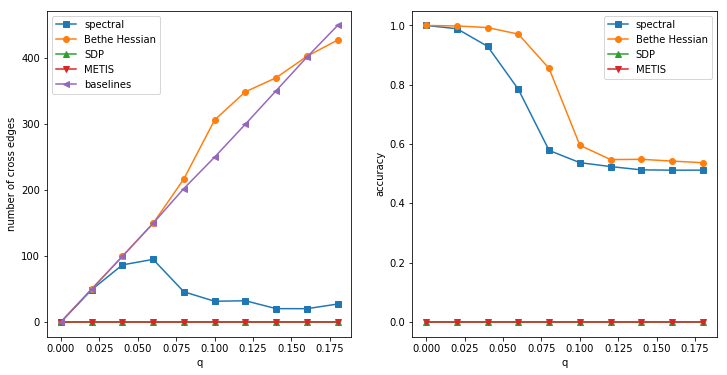

In [93]:
# your code goes here
L = 100 # number of iterations to average over
n = 100
ground_truth = np.array([0]* int(n/2) + [1]* int(n/2))
k = 2
p = 0.2
m = 5
qs = np.arange(0, 1, 0.1) * p
laplacian_num_edges = np.zeros((len(qs), L))
bethe_hessian_num_edges = np.zeros((len(qs), L))
sdp_num_edges = np.zeros((len(qs), L))
metis_num_edges = np.zeros((len(qs), L))
baselines = np.zeros((len(qs), L))

laplacian_acc = np.zeros((len(qs), L))
bethe_hessian_acc = np.zeros((len(qs), L))
sdp_acc = np.zeros((len(qs), L))
metis_acc = np.zeros((len(qs), L))

# I plotted spectral and Bethe Hessian clutering, but was unable to plot SDP or METIS because I could not complete them both
for i, q in enumerate(qs):
    for l in xrange(L):
        adjacency = SBM(n, k, p, q)
        labels_spectral = spectral_clustering(adjacency, k)
        laplacian_num_edges[i, l] = inter_cluster_edges(adjacency, labels_spectral)
        laplacian_acc[i, l] = accuracy(ground_truth, labels_spectral)
        labels_bethe = bethe_hessian_clustering(adjacency, k)
        bethe_hessian_num_edges[i, l] = inter_cluster_edges(adjacency, labels_bethe)
        bethe_hessian_acc[i, l] = accuracy(ground_truth, labels_bethe)
        baselines[i, l] = inter_cluster_edges(adjacency, ground_truth)
        
rcParams['figure.figsize'] = 12, 6
f, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot(qs, np.average(laplacian_num_edges, axis=1), marker='s', label='spectral')
ax1.plot(qs, np.average(bethe_hessian_num_edges, axis=1), marker='o', label='Bethe Hessian')
ax1.plot(qs, np.average(sdp_num_edges, axis=1), marker='^', label='SDP')
ax1.plot(qs, np.average(metis_num_edges, axis=1), marker='v', label='METIS')
ax1.plot(qs, np.average(baselines, axis=1), marker='<', label='baselines')
ax1.legend()
ax1.set_xlabel('q')
ax1.set_ylabel('number of cross edges')

ax2.plot(qs, np.average(laplacian_acc, axis=1), marker='s', label='spectral')
ax2.plot(qs, np.average(bethe_hessian_acc, axis=1), marker='o', label='Bethe Hessian')
ax2.plot(qs, np.average(sdp_acc, axis=1), marker='^', label='SDP')
ax2.plot(qs, np.average(metis_acc, axis=1), marker='v', label='METIS')
ax2.legend()
ax2.set_xlabel('q')
ax2.set_ylabel('accuracy')